**IS6055: Group-25 Assignment Code**

In [ ]:
!apt-get install -y coinor-cbc
!which cbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-cbc is already the newest version (2.10.7+ds1-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
/usr/bin/cbc


**Imports and Model Initialization**

In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
import matplotlib.pyplot as plt

# Initialize model
model = ConcreteModel()

**Sets**

In [ ]:
model.SUPPLIERS = Set(initialize=['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion'])
model.MODES = Set(initialize=['Sea', 'Air'])
model.PLANTS = Set(initialize=['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica'])
model.REGIONS = Set(initialize=['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa'])
model.PRODUCTS = Set(initialize=['A', 'B', 'C'])

**Parameters – Suppliers**

In [ ]:
model.supplier_quota = Param(model.SUPPLIERS, initialize={
    'NatureHarvest': 250000, 'PureEssence': 150000, 'MineralGlow': 400000, 'FloralFusion': 200000
},mutable=True)
model.supplier_cost = Param(model.SUPPLIERS, initialize={
    'NatureHarvest': 15, 'PureEssence': 25, 'MineralGlow': 10, 'FloralFusion': 20
},mutable=True)
model.supplier_emissions = Param(model.SUPPLIERS, model.MODES, initialize={
    ('NatureHarvest', 'Sea'): 0.5, ('NatureHarvest', 'Air'): 1.0,
    ('PureEssence', 'Air'): 1.5,
    ('MineralGlow', 'Sea'): 0.8,
    ('FloralFusion', 'Sea'): 0.6, ('FloralFusion', 'Air'): 1.0
}, default=0)
model.supplier_bonus = Param(model.SUPPLIERS, initialize={
    'NatureHarvest': 0.5, 'PureEssence': 0.5, 'MineralGlow': 0.5, 'FloralFusion': 0.5
})  # Incentive for exceeding minimum

original_quota = {
    'NatureHarvest': 250000,
    'PureEssence': 150000,
    'MineralGlow': 400000,
    'FloralFusion': 200000
}

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


**Parameters – Plants**

In [ ]:
model.plant_base_capacity = Param(model.PLANTS, initialize={
    'Europe': 800000, 'NorthAmerica': 1200000, 'Asia': 1500000, 'SouthAmerica': 600000
}, mutable=True)
model.plant_cost = Param(model.PLANTS, initialize={
    'Europe': 12, 'NorthAmerica': 10, 'Asia': 8, 'SouthAmerica': 9
})
model.plant_emissions = Param(model.PLANTS, initialize={
    'Europe': 0.8, 'NorthAmerica': 0.7, 'Asia': 0.6, 'SouthAmerica': 0.9
})
model.expand_capacity = Param(model.PLANTS, initialize={
    'Europe': 200000, 'NorthAmerica': 300000, 'Asia': 400000, 'SouthAmerica': 150000
}, mutable=True)
model.expand_cost = Param(model.PLANTS, initialize={
    'Europe': 1000000, 'NorthAmerica': 1500000, 'Asia': 2000000, 'SouthAmerica': 800000
})

**Parameters – Regional Demand**

In [ ]:
model.demand_forecast = Param(model.REGIONS, model.PRODUCTS, initialize={
    ('NorthAmerica', 'A'): 500000, ('NorthAmerica', 'B'): 400000, ('NorthAmerica', 'C'): 300000,
    ('Europe', 'A'): 300000, ('Europe', 'B'): 450000, ('Europe', 'C'): 350000,
    ('AsiaPacific', 'A'): 600000, ('AsiaPacific', 'B'): 500000, ('AsiaPacific', 'C'): 400000,
    ('SouthAmerica', 'A'): 200000, ('SouthAmerica', 'B'): 300000, ('SouthAmerica', 'C'): 200000,
    ('MiddleEast', 'A'): 250000, ('MiddleEast', 'B'): 400000, ('MiddleEast', 'C'): 300000,
    ('Africa', 'A'): 150000, ('Africa', 'B'): 200000, ('Africa', 'C'): 150000
})
model.penalty = Param(model.REGIONS, initialize={
    'NorthAmerica': 5, 'Europe': 6, 'AsiaPacific': 4, 'SouthAmerica': 6, 'MiddleEast': 7, 'Africa': 8
})
model.demand_actual = Var(model.REGIONS, model.PRODUCTS, within=NonNegativeReals)

**Transport Cost and Emissions**

In [ ]:
# Cost
transport_cost_dict = {
    ('NorthAmerica', 'NorthAmerica'): 0.7, ('NorthAmerica', 'Europe'): 3, ('NorthAmerica', 'AsiaPacific'): 5,
    ('NorthAmerica', 'SouthAmerica'): 2, ('NorthAmerica', 'MiddleEast'): 6, ('NorthAmerica', 'Africa'): 7,
    ('Europe', 'NorthAmerica'): 3, ('Europe', 'Europe'): 0.6, ('Europe', 'AsiaPacific'): 4,
    ('Europe', 'SouthAmerica'): 5, ('Europe', 'MiddleEast'): 2, ('Europe', 'Africa'): 3,
    ('Asia', 'NorthAmerica'): 5, ('Asia', 'Europe'): 4, ('Asia', 'AsiaPacific'): 0.5,
    ('Asia', 'SouthAmerica'): 6, ('Asia', 'MiddleEast'): 7, ('Asia', 'Africa'): 8,
    ('SouthAmerica', 'NorthAmerica'): 2, ('SouthAmerica', 'Europe'): 5, ('SouthAmerica', 'AsiaPacific'): 6,
    ('SouthAmerica', 'SouthAmerica'): 0.8, ('SouthAmerica', 'MiddleEast'): 7, ('SouthAmerica', 'Africa'): 9
}
model.transport_cost = Param(model.PLANTS * model.REGIONS, initialize=transport_cost_dict, mutable = True)

# Emissions
transport_emissions_dict = {
    ('NorthAmerica', 'NorthAmerica'): 0.7, ('NorthAmerica', 'Europe'): 0.15, ('NorthAmerica', 'AsiaPacific'): 0.25,
    ('NorthAmerica', 'SouthAmerica'): 0.1, ('NorthAmerica', 'MiddleEast'): 0.3, ('NorthAmerica', 'Africa'): 0.35,
    ('Europe', 'NorthAmerica'): 0.15, ('Europe', 'Europe'): 0.6, ('Europe', 'AsiaPacific'): 0.2,
    ('Europe', 'SouthAmerica'): 0.25, ('Europe', 'MiddleEast'): 0.1, ('Europe', 'Africa'): 0.15,
    ('Asia', 'NorthAmerica'): 0.25, ('Asia', 'Europe'): 0.2, ('Asia', 'AsiaPacific'): 0.5,
    ('Asia', 'SouthAmerica'): 0.3, ('Asia', 'MiddleEast'): 0.35, ('Asia', 'Africa'): 0.4,
    ('SouthAmerica', 'NorthAmerica'): 0.1, ('SouthAmerica', 'Europe'): 0.25, ('SouthAmerica', 'AsiaPacific'): 0.3,
    ('SouthAmerica', 'SouthAmerica'): 0.8, ('SouthAmerica', 'MiddleEast'): 0.35, ('SouthAmerica', 'Africa'): 0.45
}
model.transport_emissions = Param(model.PLANTS * model.REGIONS, initialize=transport_emissions_dict, mutable = True)

# Emission limits
model.max_emissions = Param(initialize=3000000, mutable=True)
model.transport_energy_emission_limit = Param(initialize=2000000)

**Decision Variables**

In [ ]:
model.x = Var(model.SUPPLIERS, model.MODES, domain=NonNegativeReals)
model.y = Var(model.PLANTS, model.PRODUCTS, domain=NonNegativeReals)
model.z = Var(model.PLANTS, model.REGIONS, model.PRODUCTS, domain=NonNegativeReals)
model.demand_actual = Var(model.REGIONS, model.PRODUCTS, domain=NonNegativeReals)
model.unmet_demand = Var(model.REGIONS, model.PRODUCTS, domain=NonNegativeReals)
model.expand = Var(model.PLANTS, domain=Binary)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


**Constraints – Material Balance and Plant Logic**

In [ ]:
def material_balance_rule(model):
    return sum(model.x[s, mode] for s in model.SUPPLIERS for mode in model.MODES) == \
           sum(model.y[p, prod] for p in model.PLANTS for prod in model.PRODUCTS)
model.MaterialBalance = Constraint(rule=material_balance_rule)

def plant_capacity_rule(model, p):
    return sum(model.y[p, prod] for prod in model.PRODUCTS) <= \
           model.plant_base_capacity[p] + model.expand[p] * model.expand_capacity[p]
model.PlantCapacity = Constraint(model.PLANTS, rule=plant_capacity_rule)

def plant_min_utilization_rule(model, p):
    return sum(model.y[p, prod] for prod in model.PRODUCTS) >= 0.1 * model.plant_base_capacity[p]
model.PlantMinUtilization = Constraint(model.PLANTS, rule=plant_min_utilization_rule)

def production_transport_rule(model, p, prod):
    return model.y[p, prod] == sum(model.z[p, r, prod] for r in model.REGIONS)
model.ProdTransport = Constraint(model.PLANTS, model.PRODUCTS, rule=production_transport_rule)

**Constraints – Demand and Emissions**

In [ ]:
def demand_fluctuation_min_rule(model, r, prod):
    min_factors = {
        'NorthAmerica': 0.9, 'Europe': 0.9, 'AsiaPacific': 0.85,
        'SouthAmerica': 0.9, 'MiddleEast': 0.9, 'Africa': 0.85
    }
    return model.demand_actual[r, prod] >= min_factors[r] * model.demand_forecast[r, prod]
model.DemandMin = Constraint(model.REGIONS, model.PRODUCTS, rule=demand_fluctuation_min_rule)

def demand_fluctuation_max_rule(model, r, prod):
    max_factors = {
        'NorthAmerica': 1.1, 'Europe': 1.1, 'AsiaPacific': 1.15,
        'SouthAmerica': 1.1, 'MiddleEast': 1.1, 'Africa': 1.15
    }
    return model.demand_actual[r, prod] <= max_factors[r] * model.demand_forecast[r, prod]
model.DemandMax = Constraint(model.REGIONS, model.PRODUCTS, rule=demand_fluctuation_max_rule)

def demand_satisfaction_rule(model, r, prod):
    return sum(model.z[p, r, prod] for p in model.PLANTS) + model.unmet_demand[r, prod] >= model.demand_actual[r, prod]
model.DemandSatisfaction = Constraint(model.REGIONS, model.PRODUCTS, rule=demand_satisfaction_rule)

def emission_limit_rule(model):
    supplier_em = sum(model.supplier_emissions[s, mode] * model.x[s, mode] for s in model.SUPPLIERS for mode in model.MODES)
    plant_em = sum(model.plant_emissions[p] * model.y[p, prod] for p in model.PLANTS for prod in model.PRODUCTS)
    transport_em = sum(model.transport_emissions[p, r] * model.z[p, r, prod]
                       for p in model.PLANTS for r in model.REGIONS for prod in model.PRODUCTS)
    return supplier_em + plant_em + transport_em <= model.max_emissions
model.EmissionLimit = Constraint(rule=emission_limit_rule)

def transport_energy_emission_rule(model):
    plant_em = sum(model.plant_emissions[p] * model.y[p, prod]
                   for p in model.PLANTS for prod in model.PRODUCTS)
    transport_em = sum(model.transport_emissions[p, r] * model.z[p, r, prod]
                       for p in model.PLANTS for r in model.REGIONS for prod in model.PRODUCTS)
    return plant_em + transport_em <= model.transport_energy_emission_limit
model.TransportEnergyEmissionLimit = Constraint(rule=transport_energy_emission_rule)

**Objective Function**

In [ ]:
def cost_objective_rule(model):
    supply_cost = sum(model.supplier_cost[s] * model.x[s, mode] for s in model.SUPPLIERS for mode in model.MODES)
    prod_cost = sum(model.plant_cost[p] * model.y[p, prod] for p in model.PLANTS for prod in model.PRODUCTS)
    trans_cost = sum(model.transport_cost[p, r] * model.z[p, r, prod]
                     for p in model.PLANTS for r in model.REGIONS for prod in model.PRODUCTS)
    expand_cost = sum(model.expand_cost[p] * model.expand[p] for p in model.PLANTS)
    supply_bonus = sum(model.supplier_bonus[s] * (sum(model.x[s, mode] for mode in model.MODES) -
                       0.9 * model.supplier_quota[s]) for s in model.SUPPLIERS)
    return supply_cost + prod_cost + trans_cost + expand_cost - supply_bonus
model.CostObjective = Expression(rule=cost_objective_rule)

def emissions_objective_rule(model):
    supplier_em = sum(model.supplier_emissions[s, mode] * model.x[s, mode]
                      for s in model.SUPPLIERS for mode in model.MODES)
    plant_em = sum(model.plant_emissions[p] * model.y[p, prod]
                   for p in model.PLANTS for prod in model.PRODUCTS)
    transport_em = sum(model.transport_emissions[p, r] * model.z[p, r, prod]
                       for p in model.PLANTS for r in model.REGIONS for prod in model.PRODUCTS)
    return supplier_em + plant_em + transport_em
model.EmissionsObjective = Expression(rule=emissions_objective_rule)

def satisfaction_objective_rule(model):
    return sum(model.penalty[r] * model.unmet_demand[r, prod]
               for r in model.REGIONS for prod in model.PRODUCTS)
model.SatisfactionObjective = Expression(rule=satisfaction_objective_rule)

w_cost = 0.3
w_emissions = 0.2
w_satisfaction = 0.5
def objective_rule(model):
    return (w_cost * model.CostObjective +
            w_emissions * model.EmissionsObjective +
            w_satisfaction * model.SatisfactionObjective)
model.OBJ = Objective(rule=objective_rule, sense=minimize)

In [ ]:
def create_bordered_table(headers, data):
    # Calculate column widths
    col_widths = [max(len(str(item)) for item in col) for col in zip(headers, *data)]

    # Create horizontal border
    border = '+' + '+'.join(['-' * (width + 2) for width in col_widths]) + '+'

    # Create header row
    header_row = '|' + '|'.join([f' {headers[i].ljust(col_widths[i])} ' for i in range(len(headers))]) + '|'

    # Build the table
    table = [border, header_row, border]
    for row in data:
        table.append('|' + '|'.join([f' {str(row[i]).ljust(col_widths[i])} ' for i in range(len(row))]) + '|')
        table.append(border)

    return '\n'.join(table)

**Scenario -1 Base Setup, Solver & Output**

In [ ]:
# Scenario Setup
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(model.demand_forecast[r, prod])

for p in model.PLANTS:
    model.expand[p].fix(0)

for s in model.SUPPLIERS:
    model.supplier_quota[s] = original_quota[s]

# Solve the model
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# Output Results
print("\n=== FINAL OPTIMAL SOLUTION ===")
summary_data = [
    ["Total supply", f"{total_supply:,.0f}"],
    ["Total production", f"{total_production:,.0f}"],
    ["Total demand (actual)", f"{total_demand:,.0f}"],
    ["Total unmet demand", f"{total_unmet:,.0f} ({total_unmet/total_demand:.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier delivery
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    supplier_data.append([s, f"{delivered:,.0f}", f"{delivered/value(model.supplier_quota[s]):.1%}"])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "% of Quota"], supplier_data))

# Plant production by products
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:,.0f}" if produced > 0 else "0"  # Show 0 instead of omitting
        ])

print("\nPlant production by product (complete):")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant utilization and expansion
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    base_cap = value(model.plant_base_capacity[p])
    expand_cap = value(model.expand_capacity[p])
    capacity = base_cap + expanded * expand_cap
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional fulfillment by product
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        demand = value(model.demand_actual[r, prod])
        if demand > 0:  # Only show products with demand
            fulfillment_data.append([
                r,
                f"Product {prod}",
                f"{fulfilled:,.0f}",
                f"{demand:,.0f}",
                f"{fulfilled/demand:.1%}",
                f"{value(model.unmet_demand[r, prod]):,.0f}"
            ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objective values
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Metric", "Value"], objective_data))

# Constraint checks
constraint_data = [
    ["Material balance", f"{total_supply:,.0f}", "==", f"{total_production:,.0f}"],
    ["Total Emissions", f"{value(model.EmissionLimit.body):,.0f}", "<=", f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions", f"{value(model.TransportEnergyEmissionLimit.body):,.0f}", "<=", f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpj58j9y0j.pyomo.lp -stat=1 -solve -solu /tmp/tmpj58j9y0j.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 39 (-38) rows, 102 (-9) columns and 282 (-110) elements
Statistics for presolved model


Problem has 39 rows, 102 columns (102 with objective) and 282 elements
There are 18 singletons with objective 
Column breakdown:
102 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
12 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
4 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
23 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 39 (-38) rows, 102 (-9) columns and 282 (-110

**Visualizations for Base Scenario**

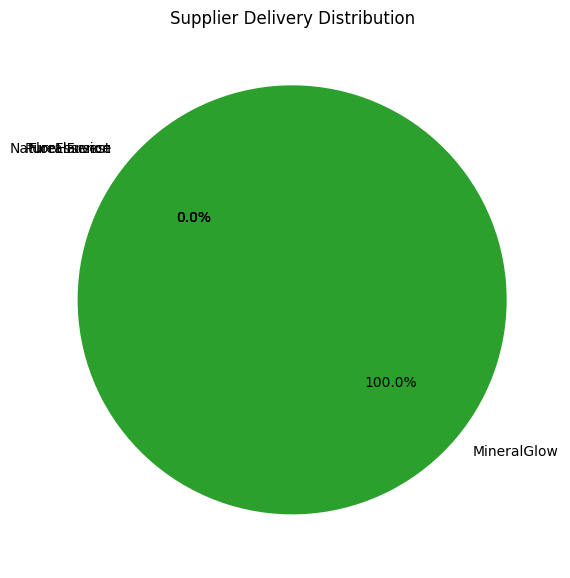

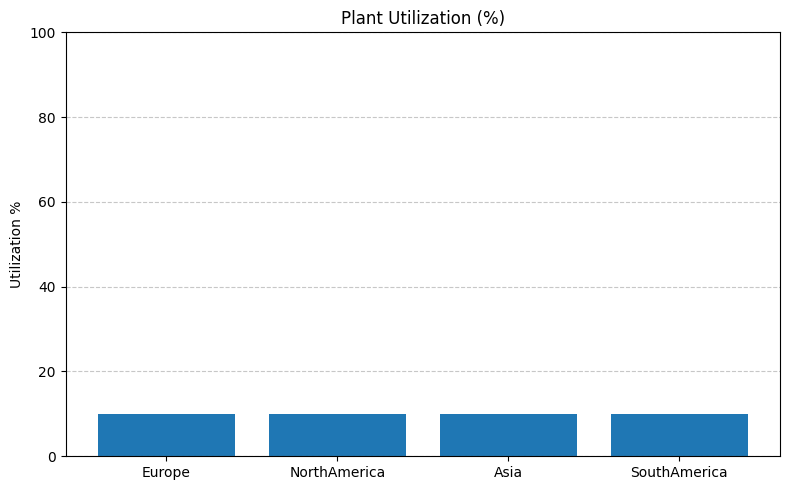

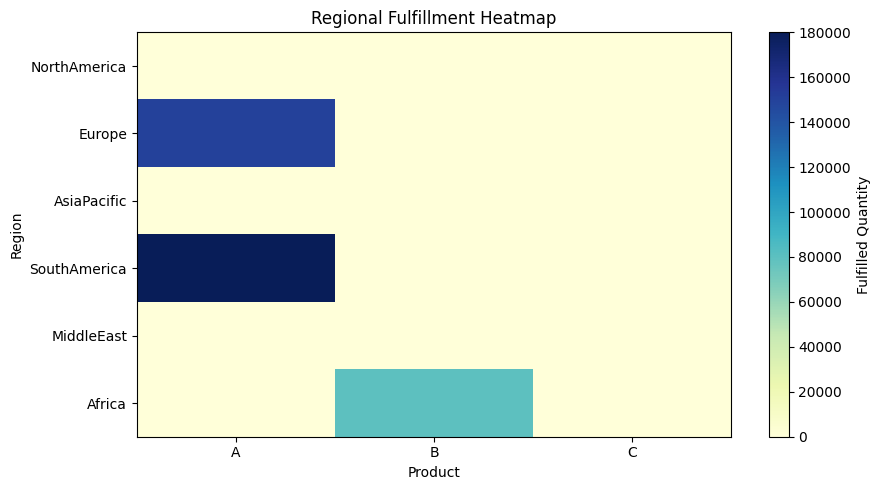

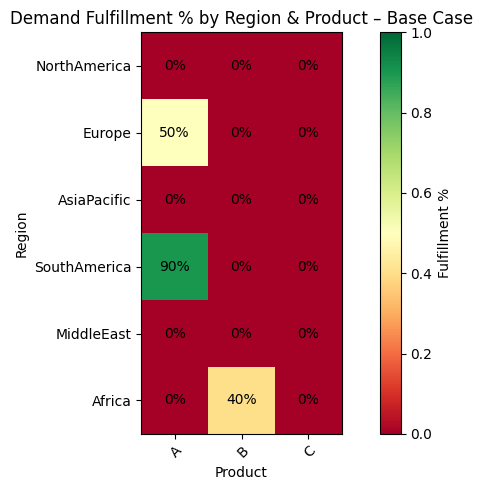

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supplier delivery data
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivery = [0, 0, 410000, 0]
quota = [400000, 150000, 400000, 200000]
delivery_pct = [d / q * 100 if q > 0 else 0 for d, q in zip(delivery, quota)]

# Plant production data
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
plant_prod = [80000, 120000, 150000, 60000]
plant_capacity = [800000, 1200000, 1500000, 600000]
plant_util_pct = [p / c * 100 for p, c in zip(plant_prod, plant_capacity)]

# Regional fulfillment data (flattened for heatmap)
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
fulfilled_matrix = [
    [0, 0, 0],           # NorthAmerica
    [150000, 0, 0],      # Europe
    [0, 0, 0],           # AsiaPacific
    [180000, 0, 0],      # SouthAmerica
    [0, 0, 0],           # MiddleEast
    [0, 80000, 0]        # Africa
]

# Pie chart for supplier contribution
plt.figure(figsize=(6, 6))
plt.pie(delivery, labels=suppliers, autopct='%1.1f%%', startangle=140)
plt.title('Supplier Delivery Distribution')
plt.tight_layout()
plt.show()

# Bar chart for plant utilization
plt.figure(figsize=(8, 5))
plt.bar(plants, plant_util_pct)
plt.title('Plant Utilization (%)')
plt.ylabel('Utilization %')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Heatmap for fulfillment
plt.figure(figsize=(9, 5))
plt.imshow(fulfilled_matrix, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Fulfilled Quantity')
plt.xticks(ticks=range(len(products)), labels=products)
plt.yticks(ticks=range(len(regions)), labels=regions)
plt.title('Regional Fulfillment Heatmap')
plt.xlabel('Product')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

# Regions and Products (keep the order consistent with your model)
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']

# Fulfillment % values from Base Case output (as decimals from 0 to 1)
fulfillment_matrix = np.array([
    [0.00, 0.00, 0.00],   # NorthAmerica
    [0.50, 0.00, 0.00],   # Europe
    [0.00, 0.00, 0.00],   # AsiaPacific
    [0.90, 0.00, 0.00],   # SouthAmerica
    [0.00, 0.00, 0.00],   # MiddleEast
    [0.00, 0.40, 0.00],   # Africa
])

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
cmap = plt.cm.RdYlGn  # Red to Green
cax = ax.imshow(fulfillment_matrix, cmap=cmap, vmin=0, vmax=1)

# Tick labels
ax.set_xticks(np.arange(len(products)))
ax.set_yticks(np.arange(len(regions)))
ax.set_xticklabels(products)
ax.set_yticklabels(regions)

# Rotate product labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate the heatmap with % values
for i in range(len(regions)):
    for j in range(len(products)):
        val = fulfillment_matrix[i, j]
        ax.text(j, i, f"{val*100:.0f}%", ha="center", va="center", color="black")

# Title and labels
plt.title("Demand Fulfillment % by Region & Product – Base Case")
plt.xlabel("Product")
plt.ylabel("Region")
fig.colorbar(cax, ax=ax, label="Fulfillment %")
plt.tight_layout()
plt.show()

**Scenario 2: SupplierMin Only**

In [ ]:
# === SCENARIO 2: Enforce SupplierMin Only ===

# 1. Add SupplierMin constraint
def supplier_min_rule(model, s):
    min_factors = {
        'NatureHarvest': 0.8,
        'PureEssence': 0.9,
        'MineralGlow': 0.85,
        'FloralFusion': 0.9
    }
    return sum(model.x[s, m] for m in model.MODES) >= min_factors[s] * model.supplier_quota[s]

model.SupplierMin = Constraint(model.SUPPLIERS, rule=supplier_min_rule)

# 2. Remove SupplierMax if it exists (ensure only SupplierMin is active)
if hasattr(model, 'SupplierMax'):
    model.del_component('SupplierMax')

# 3. Fix demand to 100% forecast
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(model.demand_forecast[r, prod])

# 4. Disable all plant expansions
for p in model.PLANTS:
    model.expand[p].fix(0)

# 5. Solve
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# 6. Print Results
print("\n=== FINAL OPTIMAL SOLUTION ===")
total_supply = sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES)
total_production = sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS)
total_demand = sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)
total_unmet = sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)

# Summary table
summary_data = [
    ["Total supply", f"{total_supply:,.0f}"],
    ["Total production", f"{total_production:,.0f}"],
    ["Total demand (actual)", f"{total_demand:,.0f}"],
    ["Total unmet demand", f"{total_unmet:,.0f} ({total_unmet/total_demand:.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier delivery
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    supplier_data.append([s, f"{delivered:,.0f}", f"{delivered/value(model.supplier_quota[s]):.1%}"])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "% of Quota"], supplier_data))

# Plant production (including zeros)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([p, f"Product {prod}", f"{produced:,.0f}"])
print("\nPlant production by product (complete):")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant utilization
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    base_cap = value(model.plant_base_capacity[p])
    expand_cap = value(model.expand_capacity[p])
    capacity = base_cap + expanded * expand_cap
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional fulfillment
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        demand = value(model.demand_actual[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:,.0f}",
            f"{demand:,.0f}",
            f"{fulfilled/demand:.1%}" if demand > 0 else "N/A",
            f"{value(model.unmet_demand[r, prod]):,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Metric", "Value"], objective_data))

# Constraints
constraint_data = [
    ["Material balance", f"{total_supply:,.0f}", "==", f"{total_production:,.0f}"],
    ["Total Emissions", f"{value(model.EmissionLimit.body):,.0f}", "<=", f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions", f"{value(model.TransportEnergyEmissionLimit.body):,.0f}", "<=", f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp6g_14hia.pyomo.lp -stat=1 -solve -solu /tmp/tmp6g_14hia.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 45 (-36) rows, 110 (-1) columns and 400 (0) elements
Statistics for presolved model


Problem has 45 rows, 110 columns (110 with objective) and 400 elements
There are 18 singletons with objective 
Column breakdown:
110 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
13 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
8 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
24 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 45 (-36) rows, 110 (-1) columns and 400 (0) elem

**Visualizations for SupplierMin**

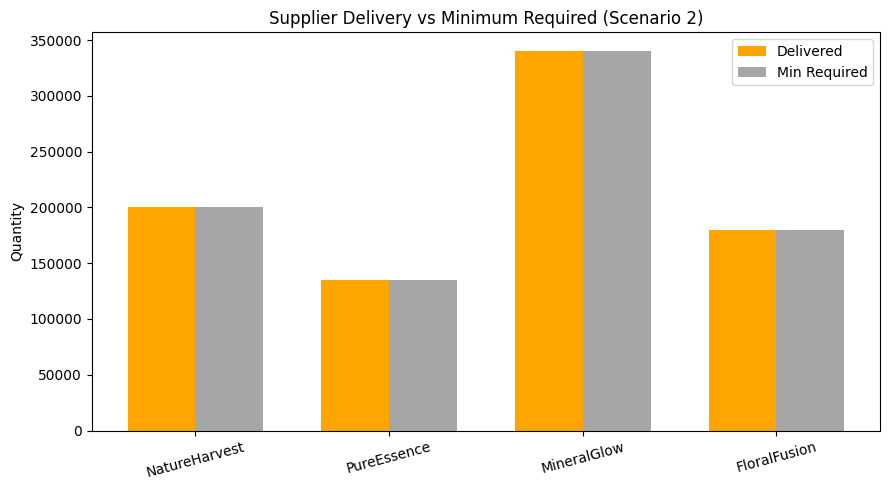

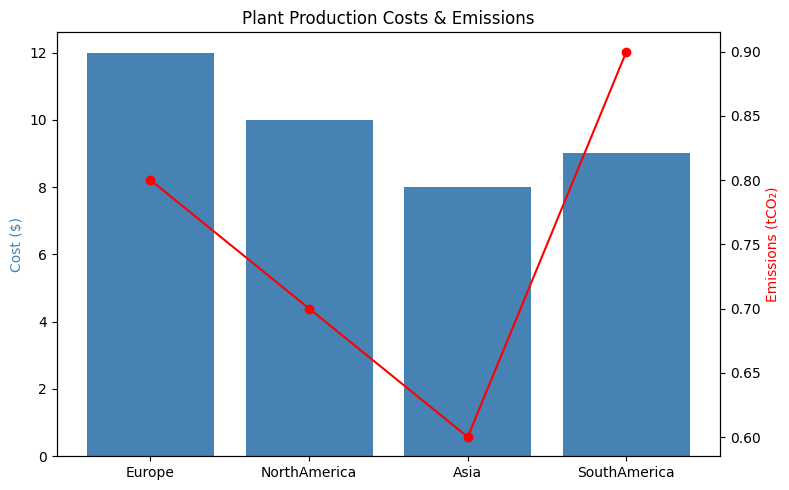

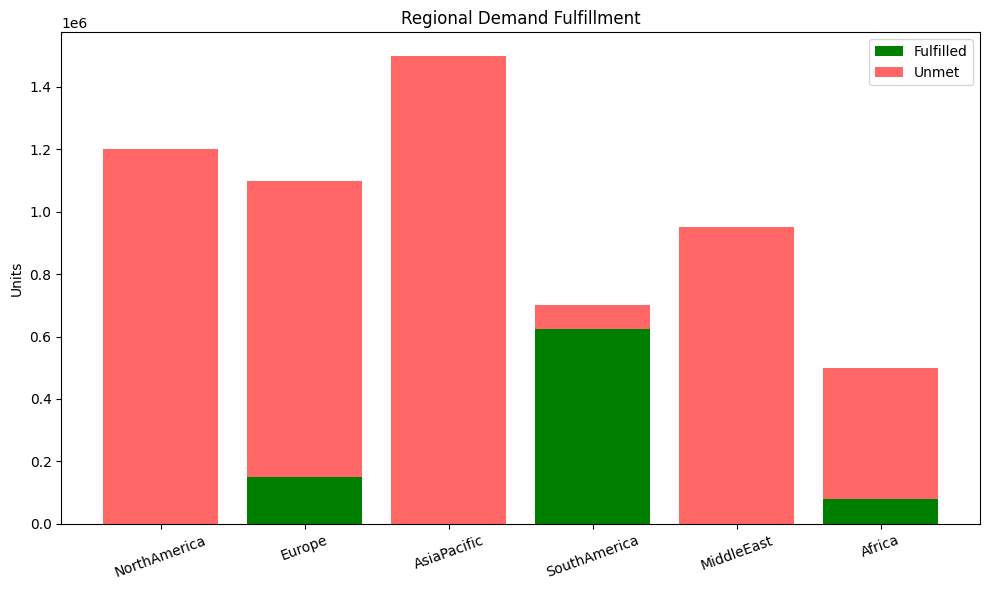

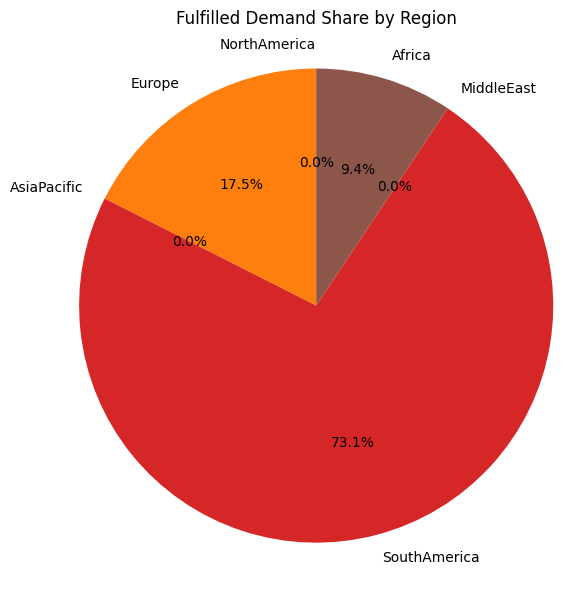

In [ ]:
# ========== Data from Scenario 2 (Supplier Min Only) ==========

# Supplier Delivery vs Quota
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivered = [200000, 135000, 340000, 180000]
quotas = [250000, 150000, 400000, 200000]
min_percent = [0.8, 0.9, 0.85, 0.9]
min_threshold = [q * m for q, m in zip(quotas, min_percent)]

# Plant Production (Bar + Line)
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
prod_costs = [12, 10, 8, 9]
emissions = [0.8, 0.7, 0.6, 0.9]

# Regional Demand Fulfillment
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
fulfilled = [0, 150000, 0, 625000, 0, 80000]
demand = [1200000, 1100000, 1500000, 700000, 950000, 500000]

# Pie chart values
pie_values = fulfilled
pie_labels = regions

# ========== PLOTS ==========

# 1. Bar Chart: Supplier Delivery vs Min Threshold
x = np.arange(len(suppliers))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - width/2, delivered, width, label='Delivered', color='orange')
ax.bar(x + width/2, min_threshold, width, label='Min Required', color='grey', alpha=0.7)

ax.set_ylabel('Quantity')
ax.set_title('Supplier Delivery vs Minimum Required (Scenario 2)')
ax.set_xticks(x)
ax.set_xticklabels(suppliers, rotation=15)
ax.legend()
plt.tight_layout()
plt.show()

# 2. Bar + Line Chart: Plant Cost vs Emissions
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(plants, prod_costs, color='steelblue', label='Cost ($)')
ax1.set_ylabel('Cost ($)', color='steelblue')
ax2 = ax1.twinx()
ax2.plot(plants, emissions, color='red', marker='o', label='Emissions (tCO₂)')
ax2.set_ylabel('Emissions (tCO₂)', color='red')
plt.title("Plant Production Costs & Emissions")
fig.tight_layout()
plt.show()

# 3. Stacked Bar Chart: Regional Fulfillment
fig, ax = plt.subplots(figsize=(10, 6))
unmet = [d - f for d, f in zip(demand, fulfilled)]
ax.bar(regions, fulfilled, label='Fulfilled', color='green')
ax.bar(regions, unmet, bottom=fulfilled, label='Unmet', color='red', alpha=0.6)
ax.set_ylabel("Units")
ax.set_title("Regional Demand Fulfillment")
ax.legend()
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 4. Pie Chart: Fulfilled Share by Region
plt.figure(figsize=(6, 6))
plt.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=90)
plt.title("Fulfilled Demand Share by Region")
plt.axis('equal')
plt.tight_layout()
plt.show()

Scenario 3: Demand Down 10%
Reduce forecasted demand by 10% across all regions and products.
- Demand fixed to 90% of original forecast
- SupplierMin and SupplierMax constraints active
- No plant expansion allowed

In [ ]:
# === SCENARIO 3: Demand Down 10% ===

# 1. Fix demand to 90% of forecast (simulate demand drop)
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(0.9 * model.demand_forecast[r, prod])

# 2. Disable all plant expansions
for p in model.PLANTS:
    model.expand[p].fix(0)

# 3. Ensure both SupplierMin and SupplierMax are active
def supplier_min_rule(model, s):
    min_factors = {
        'NatureHarvest': 0.8,
        'PureEssence': 0.9,
        'MineralGlow': 0.85,
        'FloralFusion': 0.9
    }
    return sum(model.x[s, m] for m in model.MODES) >= min_factors[s] * model.supplier_quota[s]

def supplier_max_rule(model, s):
    max_factors = {
        'NatureHarvest': 1.2,
        'PureEssence': 1.1,
        'MineralGlow': 1.15,
        'FloralFusion': 1.1
    }
    return sum(model.x[s, m] for m in model.MODES) <= max_factors[s] * model.supplier_quota[s]

model.SupplierMin = Constraint(model.SUPPLIERS, rule=supplier_min_rule)
model.SupplierMax = Constraint(model.SUPPLIERS, rule=supplier_max_rule)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Solve the Model

In [ ]:
# 4. Solve
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# 5. Print results
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Calculate totals
total_supply = sum(value(model.x[s, m]) for s in model.SUPPLIERS for m in model.MODES)
total_production = sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS)
total_demand = sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)
total_unmet = sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)

# Summary table
summary_data = [
    ["Total supply", f"{total_supply:,.0f}"],
    ["Total production", f"{total_production:,.0f}"],
    ["Total demand (actual)", f"{total_demand:,.0f}"],
    ["Total unmet demand", f"{total_unmet:,.0f} ({total_unmet/total_demand:.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier delivery table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, m]) for m in model.MODES)
    supplier_data.append([
        s,
        f"{delivered:,.0f}",
        f"{delivered/value(model.supplier_quota[s]):.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "% of Quota"], supplier_data))

# Plant production table (including zeros)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant utilization table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    base_cap = value(model.plant_base_capacity[p])
    expand_cap = value(model.expand_capacity[p])
    capacity = base_cap + expanded * expand_cap
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional fulfillment table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:,.0f}",
            f"{actual:,.0f}",
            f"{fulfilled/actual:.1%}" if actual > 0 else "N/A",
            f"{unmet:,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Metric", "Value"], objective_data))

# Constraints table
constraint_data = [
    ["Material balance", f"{total_supply:,.0f}", "==", f"{total_production:,.0f}"],
    ["Total Emissions", f"{value(model.EmissionLimit.body):,.0f}", "<=", f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions", f"{value(model.TransportEnergyEmissionLimit.body):,.0f}", "<=", f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpsxflx4t4.pyomo.lp -stat=1 -solve -solu /tmp/tmpsxflx4t4.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 110 (-1) columns and 408 (0) elements
Statistics for presolved model


Problem has 49 rows, 110 columns (110 with objective) and 408 elements
There are 18 singletons with objective 
Column breakdown:
110 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
13 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
8 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
28 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 49 (-36) rows, 110 (-1) columns and 408 (0) elem

**Visualizationa for S3**

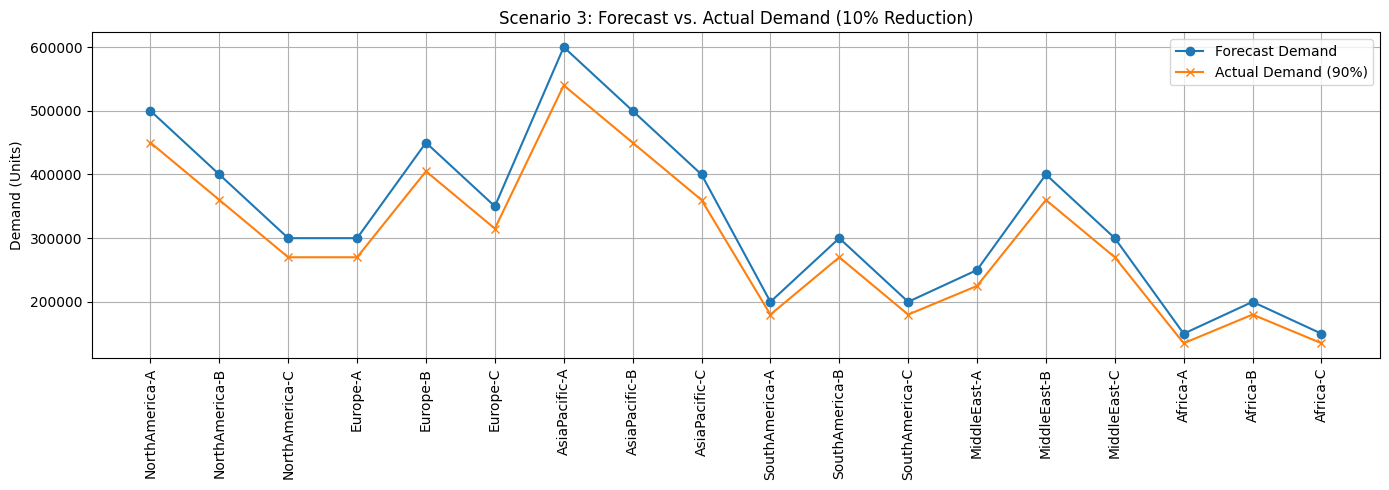

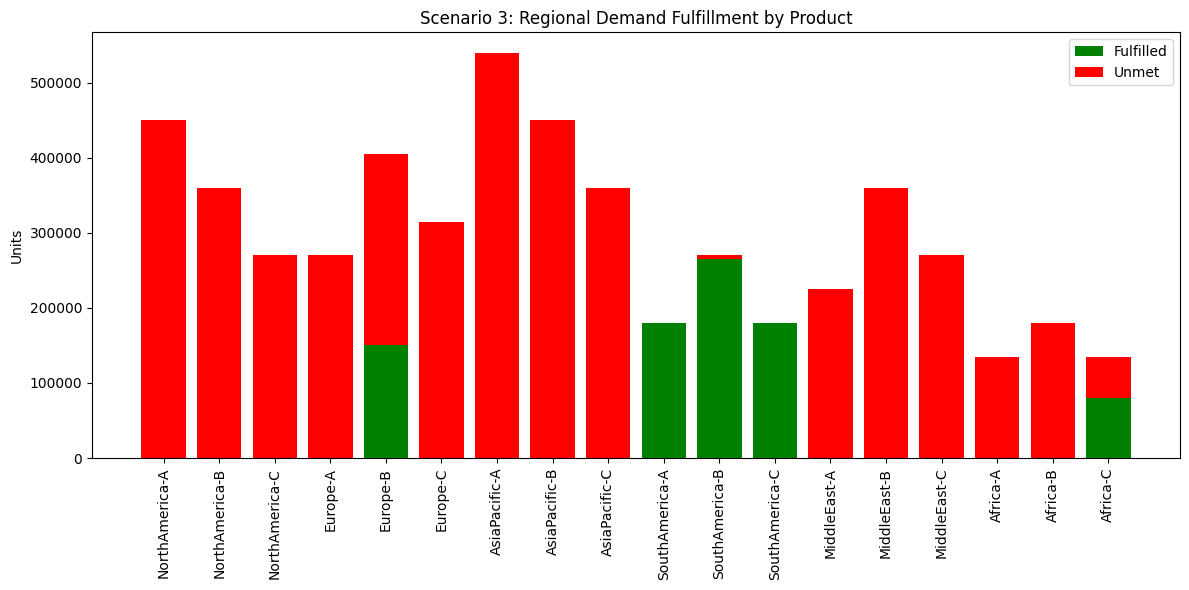

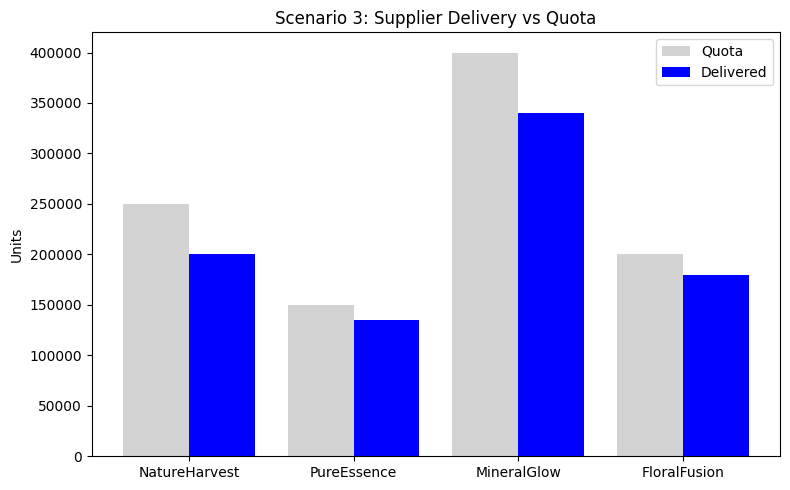

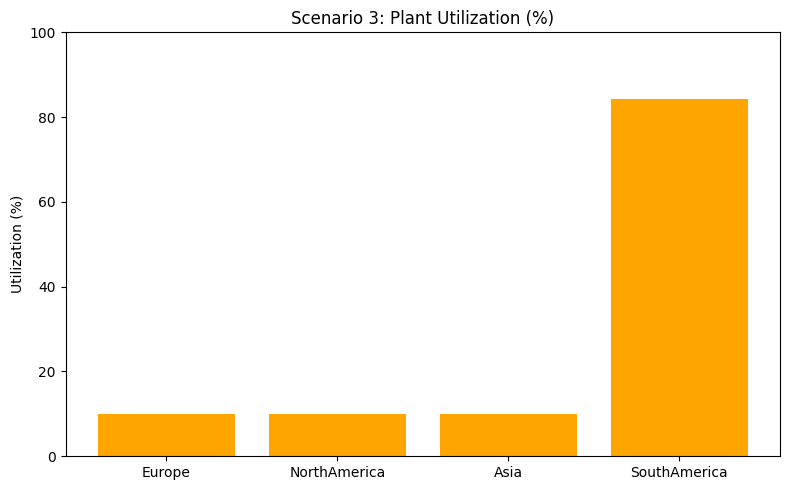

In [ ]:
import matplotlib.pyplot as plt

# Data from Scenario 3 Output
regions = [
    'NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica',
    'MiddleEast', 'Africa'
]
products = ['A', 'B', 'C']

# Forecasted demand = actual / 0.9 since it's 10% reduced
forecast_demand = {
    'NorthAmerica-A': 500000, 'NorthAmerica-B': 400000, 'NorthAmerica-C': 300000,
    'Europe-A': 300000, 'Europe-B': 450000, 'Europe-C': 350000,
    'AsiaPacific-A': 600000, 'AsiaPacific-B': 500000, 'AsiaPacific-C': 400000,
    'SouthAmerica-A': 200000, 'SouthAmerica-B': 300000, 'SouthAmerica-C': 200000,
    'MiddleEast-A': 250000, 'MiddleEast-B': 400000, 'MiddleEast-C': 300000,
    'Africa-A': 150000, 'Africa-B': 200000, 'Africa-C': 150000
}

actual_demand = {k: int(v * 0.9) for k, v in forecast_demand.items()}  # 90% of forecast
fulfilled_demand = {
    'NorthAmerica-A': 0, 'NorthAmerica-B': 0, 'NorthAmerica-C': 0,
    'Europe-A': 0, 'Europe-B': 150000, 'Europe-C': 0,
    'AsiaPacific-A': 0, 'AsiaPacific-B': 0, 'AsiaPacific-C': 0,
    'SouthAmerica-A': 180000, 'SouthAmerica-B': 265000, 'SouthAmerica-C': 180000,
    'MiddleEast-A': 0, 'MiddleEast-B': 0, 'MiddleEast-C': 0,
    'Africa-A': 0, 'Africa-B': 0, 'Africa-C': 80000
}

# Prepare for visualization
labels = list(forecast_demand.keys())
forecast_vals = [forecast_demand[k] for k in labels]
actual_vals = [actual_demand[k] for k in labels]
fulfilled_vals = [fulfilled_demand[k] for k in labels]
unmet_vals = [actual_demand[k] - fulfilled_demand[k] for k in labels]

# 1. Forecast vs Actual Demand
plt.figure(figsize=(14, 5))
plt.plot(labels, forecast_vals, label='Forecast Demand', marker='o')
plt.plot(labels, actual_vals, label='Actual Demand (90%)', marker='x')
plt.xticks(rotation=90)
plt.title("Scenario 3: Forecast vs. Actual Demand (10% Reduction)")
plt.ylabel("Demand (Units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Stacked Bar Chart for Fulfilled vs Unmet Demand
plt.figure(figsize=(12, 6))
plt.bar(labels, fulfilled_vals, label='Fulfilled', color='green')
plt.bar(labels, unmet_vals, bottom=fulfilled_vals, label='Unmet', color='red')
plt.xticks(rotation=90)
plt.title("Scenario 3: Regional Demand Fulfillment by Product")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Supplier Delivery vs Quota
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivered = [200000, 135000, 340000, 180000]
quota = [250000, 150000, 400000, 200000]

x = range(len(suppliers))
plt.figure(figsize=(8, 5))
plt.bar(x, quota, width=0.4, label='Quota', color='lightgray')
plt.bar([i + 0.4 for i in x], delivered, width=0.4, label='Delivered', color='blue')
plt.xticks([i + 0.2 for i in x], suppliers)
plt.title("Scenario 3: Supplier Delivery vs Quota")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.show()

# 4. Plant Utilization
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 150000, 505000]
capacity = [800000, 1200000, 1500000, 600000]
util_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

plt.figure(figsize=(8, 5))
plt.bar(plants, util_pct, color='orange')
plt.title("Scenario 3: Plant Utilization (%)")
plt.ylabel("Utilization (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

SCENARIO 4: Supply Down 10%

In [ ]:
# Re-declare key components to trigger Pyomo "Implicitly replacing" warnings

model.SUPPLIERS = Set(initialize=['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion'])
model.MODES = Set(initialize=['Sea', 'Air'])
model.PLANTS = Set(initialize=['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica'])
model.REGIONS = Set(initialize=['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa'])
model.PRODUCTS = Set(initialize=['A', 'B', 'C'])

model.supplier_quota = Param(model.SUPPLIERS, initialize={
    'NatureHarvest': 250000, 'PureEssence': 150000, 'MineralGlow': 400000, 'FloralFusion': 200000
}, mutable=True)

# Scenario-specific change: Drop quotas by 10%
for s in model.SUPPLIERS:
    model.supplier_quota[s] = 0.9 * model.supplier_quota[s]

# Adjust demand to 90% (simulate forecast drop)
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(0.9 * model.demand_forecast[r, prod])

# Disable plant expansions
for p in model.PLANTS:
    model.expand[p].fix(0)


# --- SOLVE ---
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# --- RESULTS ---
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    supplier_data.append([
        s,
        f"{delivered:,.0f}",
        f"{delivered/value(model.supplier_quota[s]):.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Quantity", "% of Quota"], supplier_data))

# Plant Production Table (including zeros)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        production_data.append([
            p,
            f"Product {prod}",
            f"{value(model.y[p, prod]):,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    capacity = value(model.plant_base_capacity[p]) + expanded * value(model.expand_capacity[p])
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        demand = value(model.demand_actual[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:,.0f}",
            f"{demand:,.0f}",
            f"{fulfilled/demand:.1%}" if demand > 0 else "N/A",
            f"{value(model.unmet_demand[r, prod]):,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Metric", "Value"], objective_data))

# Constraints Table
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}",
     "==",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):,.0f}",
     "<=",
     f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):,.0f}",
     "<=",
     f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpc4rd2wuj.pyomo.lp -stat=1 -solve -solu /tmp/tmpc4rd2wuj.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 110 (-1) columns and 408 (0) elements
Statistics for presolved model


Problem has 49 rows, 110 columns (110 with objective) and 408 elements
There are 18 singletons with objective 
Column breakdown:
110 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
13 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
8 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
28 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 49 (-36) rows, 110 (-1) columns and 408 (0) elem

**Visualizations for S4**

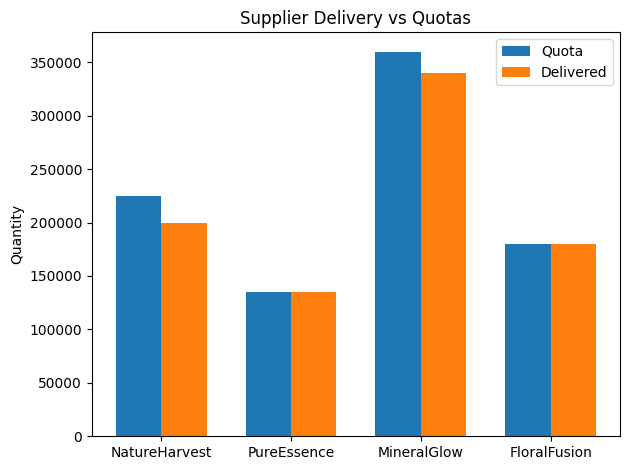

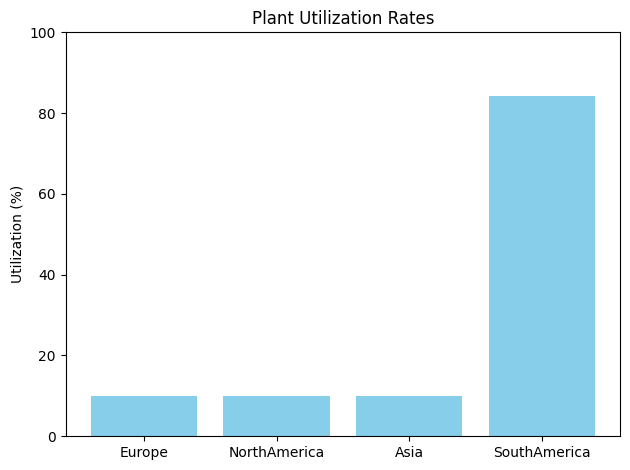

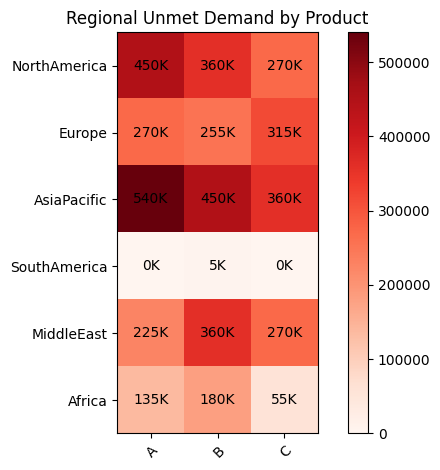

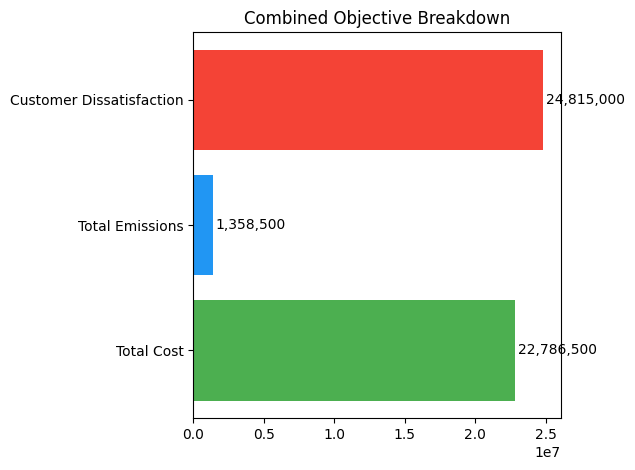

In [ ]:
# ==== SCENARIO 4: Supply Down 10% ====

# Supplier delivery (values from output)
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
quotas = [225000, 135000, 360000, 180000]  # 10% reduced
delivered = [200000, 135000, 340000, 180000]

# Plant utilization
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 150000, 505000]
capacity = [800000, 1200000, 1500000, 600000]
utilization_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

# Regional unmet demand by product
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [450000, 360000, 270000],
    [270000, 255000, 315000],
    [540000, 450000, 360000],
    [0, 5000, 0],
    [225000, 360000, 270000],
    [135000, 180000, 55000]
]

# --- Plot 1: Supplier Delivery vs Quotas ---
x = np.arange(len(suppliers))
width = 0.35
fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, quotas, width, label='Quota')
ax1.bar(x + width/2, delivered, width, label='Delivered')
ax1.set_ylabel('Quantity')
ax1.set_title('Supplier Delivery vs Quotas')
ax1.set_xticks(x)
ax1.set_xticklabels(suppliers)
ax1.legend()
plt.tight_layout()

# --- Plot 2: Plant Utilization % ---
fig2, ax2 = plt.subplots()
ax2.bar(plants, utilization_pct, color='skyblue')
ax2.set_ylabel('Utilization (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Plant Utilization Rates')
plt.tight_layout()

# --- Plot 3: Regional Unmet Demand Heatmap ---
fig3, ax3 = plt.subplots()
im = ax3.imshow(unmet_matrix, cmap='Reds')
ax3.set_xticks(np.arange(len(products)))
ax3.set_yticks(np.arange(len(regions)))
ax3.set_xticklabels(products)
ax3.set_yticklabels(regions)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(regions)):
    for j in range(len(products)):
        ax3.text(j, i, f'{unmet_matrix[i][j]//1000}K', ha="center", va="center", color="black")
ax3.set_title("Regional Unmet Demand by Product")
fig3.colorbar(im, ax=ax3)
plt.tight_layout()

# --- Plot 4: Objective Breakdown ---
labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
values = [22786500, 1358500, 24815000]
fig4, ax4 = plt.subplots()
bars = ax4.barh(labels, values, color=['#4CAF50', '#2196F3', '#f44336'])
ax4.set_title('Combined Objective Breakdown')
for bar in bars:
    width = bar.get_width()
    ax4.text(width + 200000, bar.get_y() + bar.get_height() / 2,
             f'{int(width):,}', va='center')
plt.tight_layout()

plt.show()

**SCENARIO 5: Tighten Emission Limit**

In [ ]:
# --- Step 1: Tighten emission cap ---
model.max_emissions.set_value(2000000)  # Reduced from 3M to 2M

# --- Step 2: Set demand to 110% forecast ---
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(1.10 * model.demand_forecast[r, prod])

# --- Step 3: Allow plant expansion ---
for p in model.PLANTS:
    model.expand[p].unfix()  # Allow binary expansion variable

# --- Step 4: Solve ---
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# --- Step 5: Results ---
# === FINAL OPTIMAL SOLUTION (Scenario 5: Tightened Emission Cap) ===
print("\n=== FINAL OPTIMAL SOLUTION (Scenario 5: Tightened Emission Cap) ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, m]) for s in model.SUPPLIERS for m in model.MODES):,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, m]) for m in model.MODES)
    supplier_data.append([
        s,
        f"{delivered:,.0f}",
        f"{delivered/value(model.supplier_quota[s]):.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "% of Quota"], supplier_data))

# Plant Production Table (including zeros)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        production_data.append([
            p,
            f"Product {prod}",
            f"{value(model.y[p, prod]):,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    capacity = value(model.plant_base_capacity[p]) + expanded * value(model.expand_capacity[p])
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        demand = value(model.demand_actual[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:,.0f}",
            f"{demand:,.0f}",
            f"{fulfilled/demand:.1%}" if demand > 0 else "N/A",
            f"{value(model.unmet_demand[r, prod]):,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Metric", "Value"], objective_data))

# Constraints Table
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, m]) for s in model.SUPPLIERS for m in model.MODES):,.0f}",
     "==",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):,.0f}",
     "<=",
     f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):,.0f}",
     "<=",
     f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpukktl263.pyomo.lp -stat=1 -solve -solu /tmp/tmpukktl263.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 114 (-1) columns and 412 (0) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 33 different
==== absolute objective values 33 different
==== for integers 0 zero objective 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
==== for integers absolute objective values 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
===== end objective counts


Problem has 4

**Visulaizations of Tighten Emission Limit**

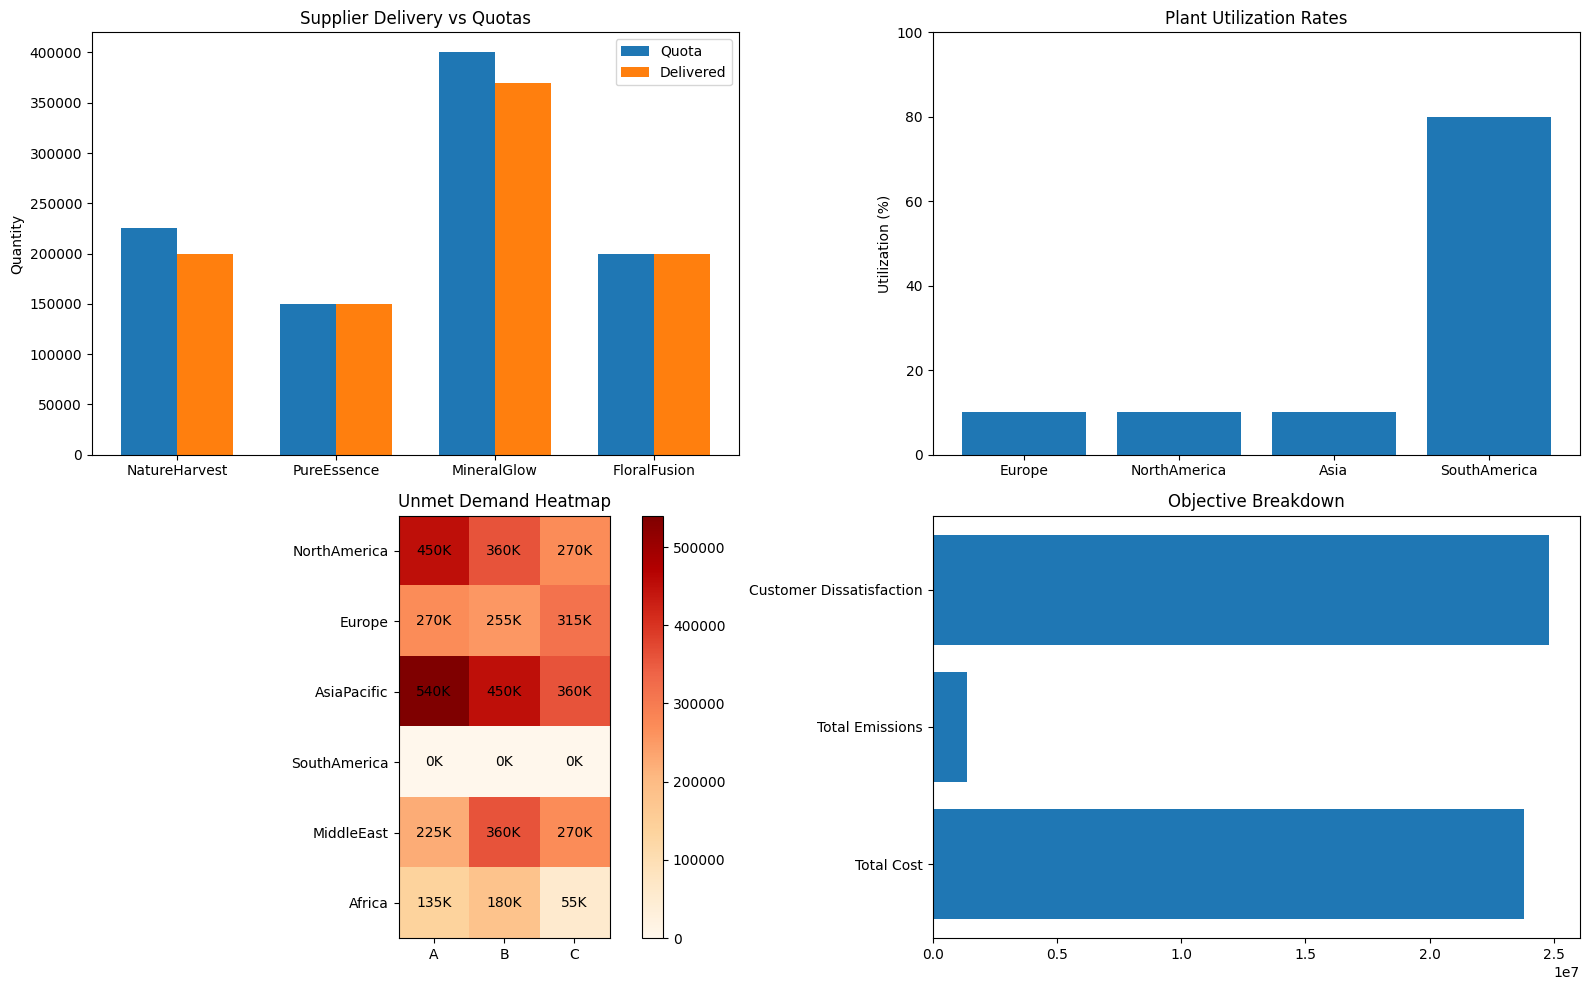

In [ ]:
# --- Scenario 5 Visualization: Tightened Emission Cap ---

# Supplier Delivery vs Quota
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
quotas = [225000, 150000, 400000, 200000]
delivered = [200000, 150000, 370000, 200000]

# Plant Utilization
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 150000, 600000]
capacity = [800000, 1200000, 1500000, 750000]
utilization_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

# Unmet Demand by Region and Product
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [450000, 360000, 270000],
    [270000, 255000, 315000],
    [540000, 450000, 360000],
    [0, 0, 0],
    [225000, 360000, 270000],
    [135000, 180000, 55000]
]

# Objective Breakdown
labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
values = [23786500, 1358500, 24815000]

# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# 1. Supplier Delivery
x = np.arange(len(suppliers))
width = 0.35
axs[0, 0].bar(x - width/2, quotas, width, label='Quota')
axs[0, 0].bar(x + width/2, delivered, width, label='Delivered')
axs[0, 0].set_ylabel('Quantity')
axs[0, 0].set_title('Supplier Delivery vs Quotas')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(suppliers)
axs[0, 0].legend()

# 2. Plant Utilization
axs[0, 1].bar(plants, utilization_pct)
axs[0, 1].set_ylabel('Utilization (%)')
axs[0, 1].set_ylim(0, 100)
axs[0, 1].set_title('Plant Utilization Rates')

# 3. Unmet Demand Heatmap
im = axs[1, 0].imshow(unmet_matrix, cmap='OrRd')
axs[1, 0].set_xticks(np.arange(len(products)))
axs[1, 0].set_yticks(np.arange(len(regions)))
axs[1, 0].set_xticklabels(products)
axs[1, 0].set_yticklabels(regions)
for i in range(len(regions)):
    for j in range(len(products)):
        axs[1, 0].text(j, i, f'{unmet_matrix[i][j]//1000}K', ha='center', va='center', color='black')
axs[1, 0].set_title("Unmet Demand Heatmap")
fig.colorbar(im, ax=axs[1, 0])

# 4. Objective Breakdown
axs[1, 1].barh(labels, values)
axs[1, 1].set_title('Objective Breakdown')

plt.tight_layout()
plt.show()

**SCENARIO 6: Prioritize Emissions**

In [ ]:
# =============================
# Scenario: Prioritize Emissions
# Objective Weights → Emissions: 50%, Cost: 20%, Dissatisfaction: 30%
# Demand = 110% of forecast | Plant Expansion allowed
# =============================

# Unfix demand_actual values (if already fixed)
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()

# Set demand_actual to 110% of forecast
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(1.10 * model.demand_forecast[r, prod])

# Allow plant expansions
for p in model.PLANTS:
    model.expand[p].unfix()

# Reset and define new objective weights
w_cost = 0.2
w_emissions = 0.5
w_satisfaction = 0.3

# Rebuild objective with updated weights
if hasattr(model, 'OBJ'):
    model.del_component('OBJ')

model.OBJ = Objective(
    rule=lambda m: (
        w_cost * m.CostObjective +
        w_emissions * m.EmissionsObjective +
        w_satisfaction * m.SatisfactionObjective
    ),
    sense=minimize
)

# Solve the model
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# Display results
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:,.0f}",
        f"{quota:,.0f}",
        f"{delivered/quota:.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "Quota", "% of Quota"], supplier_data))

# Plant Production Table (including zeros)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    base_cap = value(model.plant_base_capacity[p])
    expand_cap = value(model.expand_capacity[p])
    capacity = base_cap + expanded * expand_cap
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:,.0f}",
            f"{actual:,.0f}",
            f"{fulfilled/actual:.1%}" if actual > 0 else "N/A",
            f"{unmet:,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Metric", "Value"], objective_data))

# Constraints Table
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}",
     "==",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):,.0f}",
     "<=",
     f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):,.0f}",
     "<=",
     f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp2rwwjevq.pyomo.lp -stat=1 -solve -solu /tmp/tmp2rwwjevq.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 114 (-1) columns and 412 (0) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 31 different
==== absolute objective values 31 different
==== for integers 0 zero objective 4 different
1 variables have objective of 160000
1 variables have objective of 200000
1 variables have objective of 300000
1 variables have objective of 400000
==== for integers absolute objective values 4 different
1 variables have objective of 160000
1 variables have objective of 200000
1 variables have objective of 300000
1 variables have objective of 400000
===== end objective counts


Problem has 4

**Visualizations of Scenario: Prioritize Emissions**

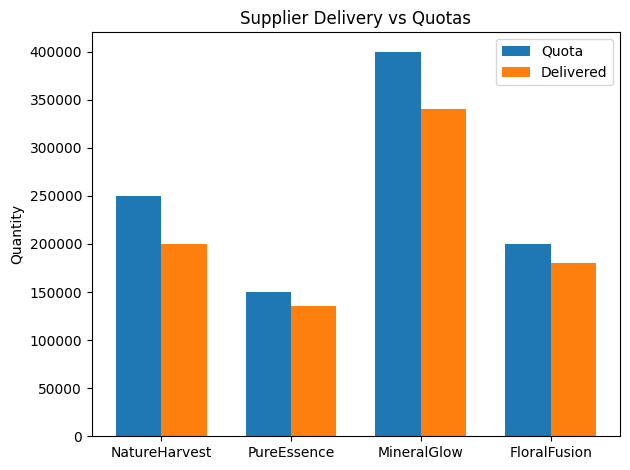

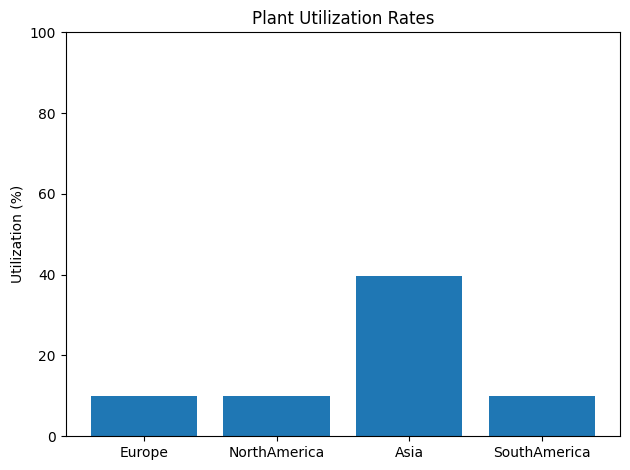

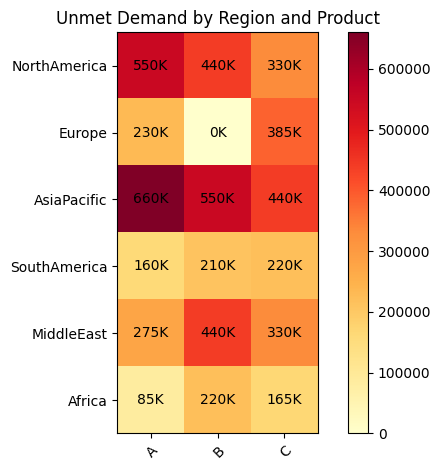

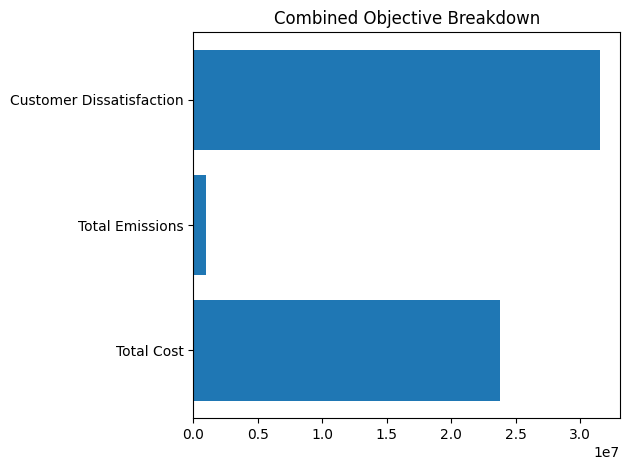

In [ ]:
# ==== Scenario: Prioritize Emissions ====

# Supplier delivery (from actual output)
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivered = [200000, 135000, 340000, 180000]
quotas = [250000, 150000, 400000, 200000]

# Plant utilization (from actual output)
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 595000, 60000]
capacity = [800000, 1200000, 1500000, 600000]
utilization_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

# Regional unmet demand by product (from output)
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [550000, 440000, 330000],
    [230000, 0, 385000],
    [660000, 550000, 440000],
    [160000, 210000, 220000],
    [275000, 440000, 330000],
    [85000, 220000, 165000]
]

# Objective values (from actual output)
objective_labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
objective_values = [23765500, 958000, 31505000]

# --- Plot 1: Supplier Delivery vs Quotas ---
x = np.arange(len(suppliers))
width = 0.35
fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, quotas, width, label='Quota')
ax1.bar(x + width/2, delivered, width, label='Delivered')
ax1.set_ylabel('Quantity')
ax1.set_title('Supplier Delivery vs Quotas')
ax1.set_xticks(x)
ax1.set_xticklabels(suppliers)
ax1.legend()
plt.tight_layout()

# --- Plot 2: Plant Utilization % ---
fig2, ax2 = plt.subplots()
ax2.bar(plants, utilization_pct)
ax2.set_ylabel('Utilization (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Plant Utilization Rates')
plt.tight_layout()

# --- Plot 3: Regional Unmet Demand Heatmap ---
fig3, ax3 = plt.subplots()
im = ax3.imshow(unmet_matrix, cmap='YlOrRd')
ax3.set_xticks(np.arange(len(products)))
ax3.set_yticks(np.arange(len(regions)))
ax3.set_xticklabels(products)
ax3.set_yticklabels(regions)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(regions)):
    for j in range(len(products)):
        ax3.text(j, i, f'{unmet_matrix[i][j]//1000}K', ha="center", va="center", color="black")
ax3.set_title("Unmet Demand by Region and Product")
fig3.colorbar(im, ax=ax3)
plt.tight_layout()

# --- Plot 4: Objective Breakdown ---
fig4, ax4 = plt.subplots()
ax4.barh(objective_labels, objective_values)
ax4.set_title('Combined Objective Breakdown')
plt.tight_layout()

# --- Show All ---
plt.show()

**Scenario 7: Prioritize Customer satisfaction**

In [ ]:
# === SCENARIO: Prioritize Customer Satisfaction ===

# Unfix demand_actual values if previously fixed
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()

# Fix demand_actual to 110% of forecast
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(1.10 * model.demand_forecast[r, prod])

# Unfix plant expansion variables
for p in model.PLANTS:
    model.expand[p].unfix()

# Update objective function weights to prioritize satisfaction
w_cost = 0.2
w_emissions = 0.1
w_satisfaction = 0.7

model.OBJ.deactivate()

def objective_rule(model):
    return (w_cost * model.CostObjective +
            w_emissions * model.EmissionsObjective +
            w_satisfaction * model.SatisfactionObjective)
model.OBJ = Objective(rule=objective_rule, sense=minimize)

# Solve
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# Print Results
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_headers = ["Metric", "Value"]
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):.1%})"]
]
print(create_bordered_table(summary_headers, summary_data))

# Supplier Delivery Table
supplier_headers = ["Supplier", "Delivered", "Quota", "% of Quota"]
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:>10,.0f}",
        f"{quota:>10,.0f}",
        f"{delivered/quota:>10.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(supplier_headers, supplier_data))

# Plant Production Table
production_headers = ["Plant", "Product", "Quantity"]
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:>10,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(production_headers, production_data))

# Plant Utilization Table
utilization_headers = ["Plant", "Utilized", "Capacity", "Utilization", "Expanded"]
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    base_cap = value(model.plant_base_capacity[p])
    expand_cap = value(model.expand_capacity[p])
    capacity = base_cap + expanded * expand_cap
    utilization_data.append([
        p,
        f"{utilized:>10,.0f}",
        f"{capacity:>10,.0f}",
        f"{utilized/capacity:>10.1%}",
        "✓" if expanded else "✗"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(utilization_headers, utilization_data))

# Regional Fulfillment Table
fulfillment_headers = ["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"]
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:>10,.0f}",
            f"{actual:>10,.0f}",
            f"{fulfilled/actual:>10.1%}" if actual > 0 else "N/A".center(10),
            f"{unmet:>10,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(fulfillment_headers, fulfillment_data))

# Objectives Table
objective_headers = ["Objective", "Value"]
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):>15,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):>15,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):>15,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):>15,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(objective_headers, objective_data))

# Constraints Table
constraint_headers = ["Constraint", "Value", "", "Limit"]
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}",
     "==",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):>15,.0f}",
     "<=",
     f"{model.max_emissions.value:>15,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):>15,.0f}",
     "<=",
     f"{model.transport_energy_emission_limit.value:>15,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(constraint_headers, constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpk1yq5w4i.pyomo.lp -stat=1 -solve -solu /tmp/tmpk1yq5w4i.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 114 (-1) columns and 412 (0) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 32 different
==== absolute objective values 32 different
==== for integers 0 zero objective 4 different
1 variables have objective of 160000
1 variables have objective of 200000
1 variables have objective of 300000
1 variables have objective of 400000
==== for integers absolute objective values 4 different
1 variables have objective of 160000
1 variables have objective of 200000
1 variables have objective of 300000
1 variables have objective of 400000
===== end objective counts


Problem has 4

**Visualizations for Prioritizing Customer Satisfaction**

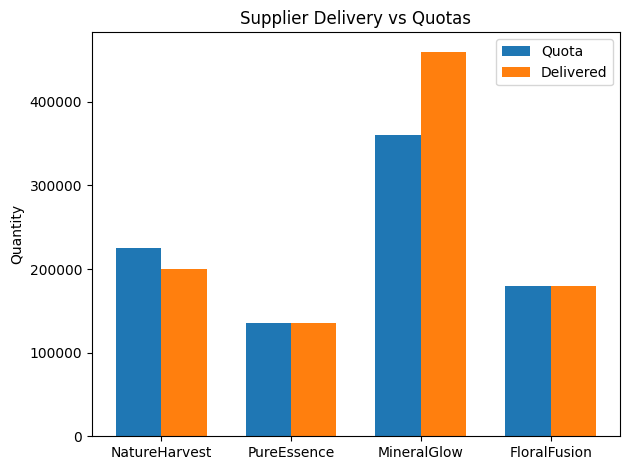

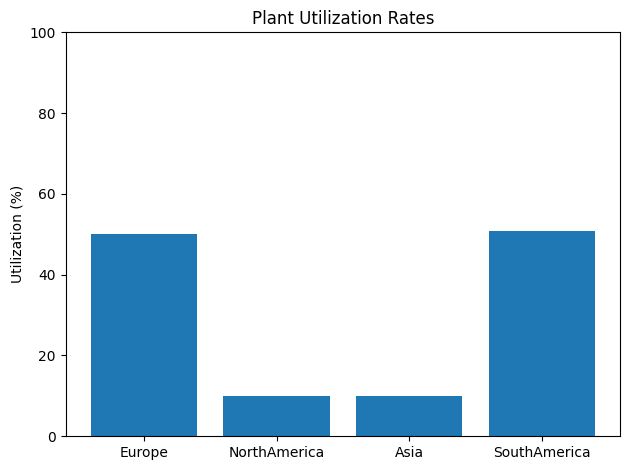

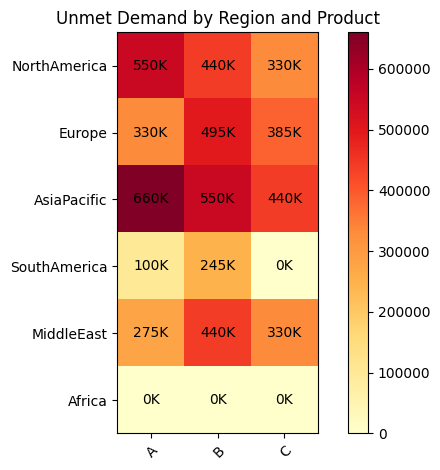

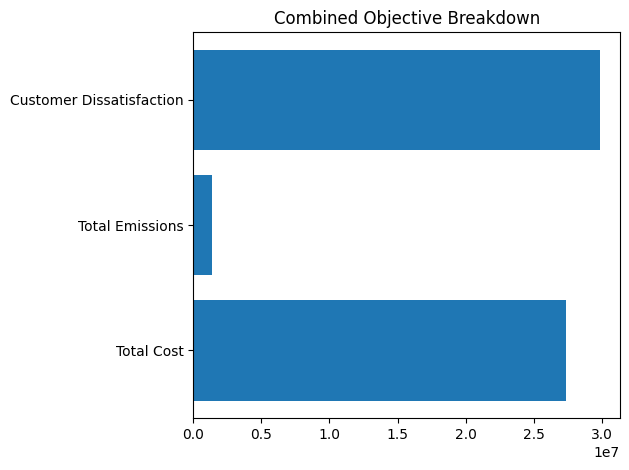

In [ ]:
# ==== Scenario: Prioritize Customer Satisfaction ====

# Supplier delivery (from output)
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivered = [200000, 135000, 460000, 180000]
quotas = [225000, 135000, 360000, 180000]  # Updated quotas after previous reductions

# Plant utilization
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [400000, 120000, 150000, 305000]
capacity = [800000, 1200000, 1500000, 600000]
utilization_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

# Regional unmet demand by product (from output)
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [550000, 440000, 330000],
    [330000, 495000, 385000],
    [660000, 550000, 440000],
    [100000, 245000, 0],
    [275000, 440000, 330000],
    [0, 0, 0]
]

# Objective values
objective_labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
objective_values = [27366500, 1352500, 29845000]

# --- Plot 1: Supplier Delivery vs Quotas ---
x = np.arange(len(suppliers))
width = 0.35
fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, quotas, width, label='Quota')
ax1.bar(x + width/2, delivered, width, label='Delivered')
ax1.set_ylabel('Quantity')
ax1.set_title('Supplier Delivery vs Quotas')
ax1.set_xticks(x)
ax1.set_xticklabels(suppliers)
ax1.legend()
plt.tight_layout()

# --- Plot 2: Plant Utilization % ---
fig2, ax2 = plt.subplots()
ax2.bar(plants, utilization_pct)
ax2.set_ylabel('Utilization (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Plant Utilization Rates')
plt.tight_layout()

# --- Plot 3: Regional Unmet Demand Heatmap ---
fig3, ax3 = plt.subplots()
im = ax3.imshow(unmet_matrix, cmap='YlOrRd')
ax3.set_xticks(np.arange(len(products)))
ax3.set_yticks(np.arange(len(regions)))
ax3.set_xticklabels(products)
ax3.set_yticklabels(regions)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(regions)):
    for j in range(len(products)):
        ax3.text(j, i, f'{unmet_matrix[i][j]//1000}K', ha="center", va="center", color="black")
ax3.set_title("Unmet Demand by Region and Product")
fig3.colorbar(im, ax=ax3)
plt.tight_layout()

# --- Plot 4: Objective Breakdown ---
fig4, ax4 = plt.subplots()
ax4.barh(objective_labels, objective_values)
ax4.set_title('Combined Objective Breakdown')
plt.tight_layout()

plt.show()

**Scenario 8: Pessimistic Case (Minimum Supply + Maximum Demand)**

In [ ]:
# ================================
# Scenario: Pessimistic Case (Min Supply + Max Demand)
# ================================

#Adjust supply quotas (minimum levels)
model.supplier_quota['NatureHarvest'] = 250000 * 0.80
model.supplier_quota['PureEssence'] = 150000 * 0.90
model.supplier_quota['MineralGlow'] = 400000 * 0.85
model.supplier_quota['FloralFusion'] = 200000 * 0.90

#Unfix and set demand to maximum levels (110% or 115%)
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()

demand_multiplier = {
    'NorthAmerica': 1.10, 'Europe': 1.10, 'AsiaPacific': 1.15,
    'SouthAmerica': 1.10, 'MiddleEast': 1.10, 'Africa': 1.15
}
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(demand_multiplier[r] * model.demand_forecast[r, prod])

#Allow plant expansions
for p in model.PLANTS:
    model.expand[p].unfix()

#Update objective function weights to prioritize satisfaction
w_cost = 0.3
w_emissions = 0.2
w_satisfaction = 0.5

model.OBJ.deactivate()

def objective_rule(model):
    return (w_cost * model.CostObjective +
            w_emissions * model.EmissionsObjective +
            w_satisfaction * model.SatisfactionObjective)
model.OBJ = Objective(rule=objective_rule, sense=minimize)

#Solve
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# Output
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_headers = ["Metric", "Value"]
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):.1%})"]
]
print(create_bordered_table(summary_headers, summary_data))

# Supplier Delivery Table
supplier_headers = ["Supplier", "Delivered", "Quota", "% of Quota"]
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:,.0f}",
        f"{quota:,.0f}",
        f"{delivered/quota:.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(supplier_headers, supplier_data))

# Plant Production Table
production_headers = ["Plant", "Product", "Quantity"]
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(production_headers, production_data))

# Plant Utilization Table
utilization_headers = ["Plant", "Utilized", "Capacity", "Utilization", "Expanded"]
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    base_cap = value(model.plant_base_capacity[p])
    expand_cap = value(model.expand_capacity[p])
    capacity = base_cap + expanded * expand_cap
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "✓" if expanded else "✗"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(utilization_headers, utilization_data))

# Regional Fulfillment Table
fulfillment_headers = ["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"]
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:,.0f}",
            f"{actual:,.0f}",
            f"{fulfilled/actual:.1%}" if actual > 0 else "N/A",
            f"{unmet:,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(fulfillment_headers, fulfillment_data))

# Objectives Table
objective_headers = ["Objective", "Value"]
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(objective_headers, objective_data))

# Constraints Table
constraint_headers = ["Constraint", "Value", "", "Limit"]
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}",
     "==",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):,.0f}",
     "<=",
     f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):,.0f}",
     "<=",
     f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(constraint_headers, constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpkas18t_3.pyomo.lp -stat=1 -solve -solu /tmp/tmpkas18t_3.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 114 (-1) columns and 412 (0) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 33 different
==== absolute objective values 33 different
==== for integers 0 zero objective 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
==== for integers absolute objective values 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
===== end objective counts


Problem has 4

**Visualizations of Scenario: Pessimistic Case (Min Supply + Max Demand)**

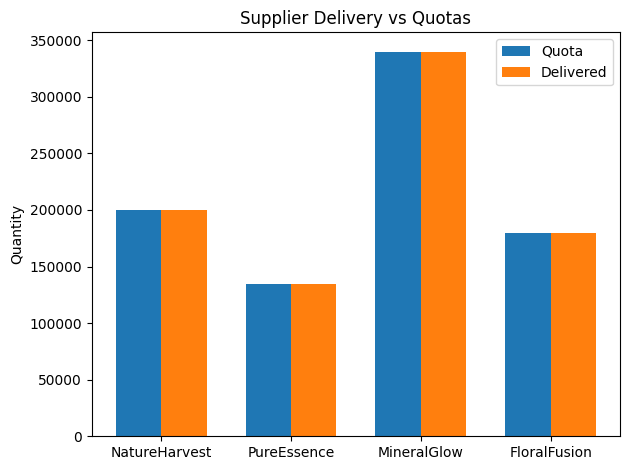

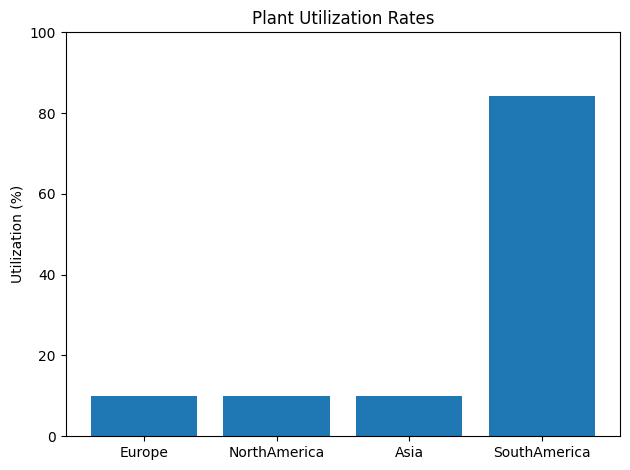

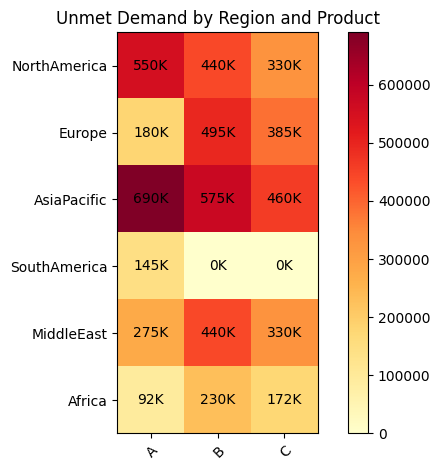

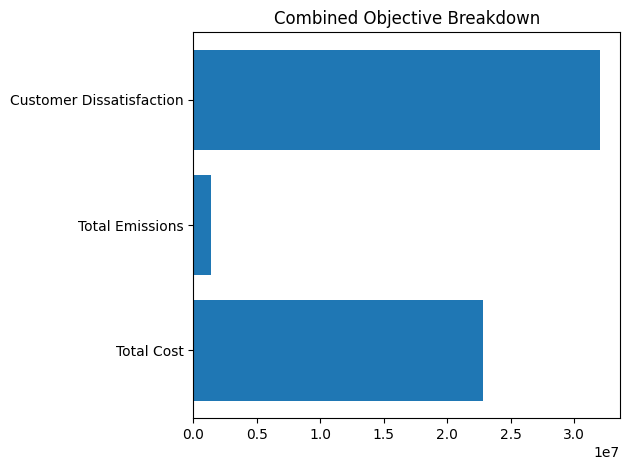

In [ ]:
# ==== Scenario: Pessimistic Case (Min Supply + Max Demand) ====

# 1. Supplier Delivery vs Quotas
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
quotas = [200000, 135000, 340000, 180000]
delivered = [200000, 135000, 340000, 180000]

# 2. Plant Utilization
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 150000, 505000]
capacity = [800000, 1200000, 1500000, 600000]
utilization_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

# 3. Unmet Demand Heatmap
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [550000, 440000, 330000],
    [180000, 495000, 385000],
    [690000, 575000, 460000],
    [145000, 0, 0],
    [275000, 440000, 330000],
    [92500, 230000, 172500]
]

# 4. Objective Breakdown
objective_labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
objective_values = [22786500, 1358500, 32005000]

# --- Plot 1: Supplier Delivery vs Quotas ---
x = np.arange(len(suppliers))
width = 0.35
fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, quotas, width, label='Quota')
ax1.bar(x + width/2, delivered, width, label='Delivered')
ax1.set_ylabel('Quantity')
ax1.set_title('Supplier Delivery vs Quotas')
ax1.set_xticks(x)
ax1.set_xticklabels(suppliers)
ax1.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Plant Utilization % ---
fig2, ax2 = plt.subplots()
ax2.bar(plants, utilization_pct)
ax2.set_ylabel('Utilization (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Plant Utilization Rates')
plt.tight_layout()
plt.show()

# --- Plot 3: Unmet Demand Heatmap ---
fig3, ax3 = plt.subplots()
im = ax3.imshow(unmet_matrix, cmap='YlOrRd')
ax3.set_xticks(np.arange(len(products)))
ax3.set_yticks(np.arange(len(regions)))
ax3.set_xticklabels(products)
ax3.set_yticklabels(regions)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(regions)):
    for j in range(len(products)):
        ax3.text(j, i, f'{unmet_matrix[i][j]//1000}K', ha="center", va="center", color="black")
ax3.set_title("Unmet Demand by Region and Product")
fig3.colorbar(im, ax=ax3)
plt.tight_layout()
plt.show()

# --- Plot 4: Objective Breakdown ---
fig4, ax4 = plt.subplots()
ax4.barh(objective_labels, objective_values)
ax4.set_title('Combined Objective Breakdown')
plt.tight_layout()
plt.show()

**Optimistic Case: Max Supply + Base Demand (100%)**

In [ ]:
# ================================
# Scenario S1: Optimistic Case (+10% Supplier Costs)
# ================================

#Adjust supply quotas (full availability)
model.supplier_quota['NatureHarvest'] = 300000
model.supplier_quota['PureEssence'] = 165000
model.supplier_quota['MineralGlow'] = 460000
model.supplier_quota['FloralFusion'] = 220000

#Unfix demand
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()

#Allow plant expansions
for p in model.PLANTS:
    model.expand[p].unfix()

#Increase supplier costs by 10%
for s in model.SUPPLIERS:
    model.supplier_cost[s] = 1.10 * value(model.supplier_cost[s])

#Update objective function weights to prioritize satisfaction
w_cost = 0.3
w_emissions = 0.2
w_satisfaction = 0.5

model.OBJ.deactivate()

def objective_rule(model):
    return (w_cost * model.CostObjective +
            w_emissions * model.EmissionsObjective +
            w_satisfaction * model.SatisfactionObjective)

model.OBJ = Objective(rule=objective_rule, sense=minimize)

#Solve
solver = SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

#Output
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_headers = ["Metric", "Value"]
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):.1%})"]
]
print(create_bordered_table(summary_headers, summary_data))

# Supplier Delivery Table
supplier_headers = ["Supplier", "Delivered", "Quota", "% of Quota"]
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:,.0f}",
        f"{quota:,.0f}",
        f"{delivered/quota:.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(supplier_headers, supplier_data))

# Plant Production Table
production_headers = ["Plant", "Product", "Quantity"]
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(production_headers, production_data))

# Plant Utilization Table
utilization_headers = ["Plant", "Utilized", "Capacity", "Utilization", "Expanded"]
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    base_cap = value(model.plant_base_capacity[p])
    expand_cap = value(model.expand_capacity[p])
    capacity = base_cap + expanded * expand_cap
    utilization_data.append([
        p,
        f"{utilized:,.0f}",
        f"{capacity:,.0f}",
        f"{utilized/capacity:.1%}",
        "✓" if expanded else "✗"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(utilization_headers, utilization_data))

# Regional Fulfillment Table
fulfillment_headers = ["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"]
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:,.0f}",
            f"{actual:,.0f}",
            f"{fulfilled/actual:.1%}" if actual > 0 else "N/A",
            f"{unmet:,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(fulfillment_headers, fulfillment_data))

# Objectives Table
objective_headers = ["Objective", "Value"]
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(objective_headers, objective_data))

# Constraints Table
constraint_headers = ["Constraint", "Value", "", "Limit"]
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):,.0f}",
     "==",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):,.0f}",
     "<=",
     f"{model.max_emissions.value:,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):,.0f}",
     "<=",
     f"{model.transport_energy_emission_limit.value:,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(constraint_headers, constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpi3w1kzvk.pyomo.lp -stat=1 -solve -solu /tmp/tmpi3w1kzvk.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 47 (-38) rows, 112 (-21) columns and 404 (-62) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 31 different
==== absolute objective values 31 different
==== for integers 0 zero objective 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
==== for integers absolute objective values 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
===== end objective counts


Problem ha

**Visualizations of Scenario S1: Optimistic Case (+10% Supplier Costs)**

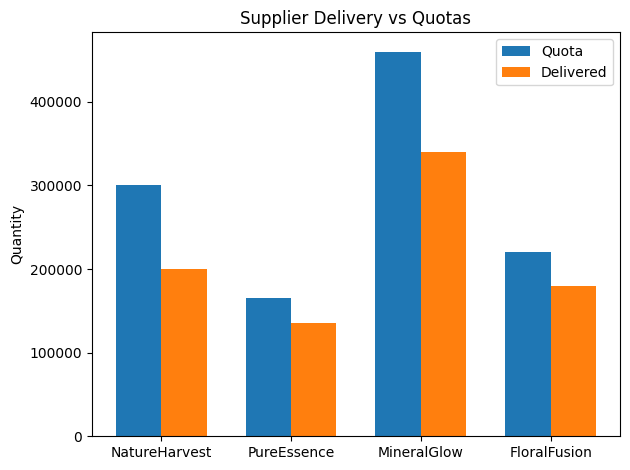

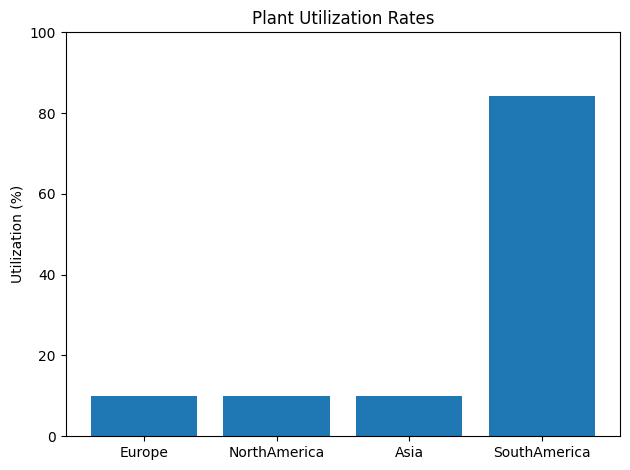

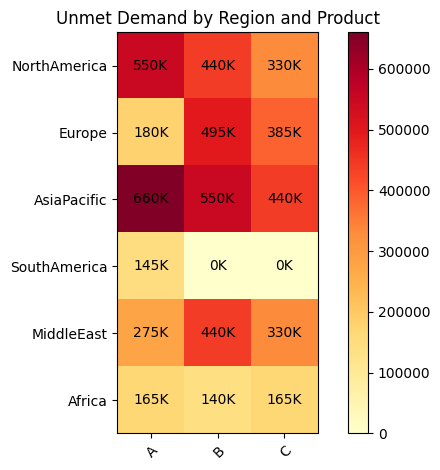

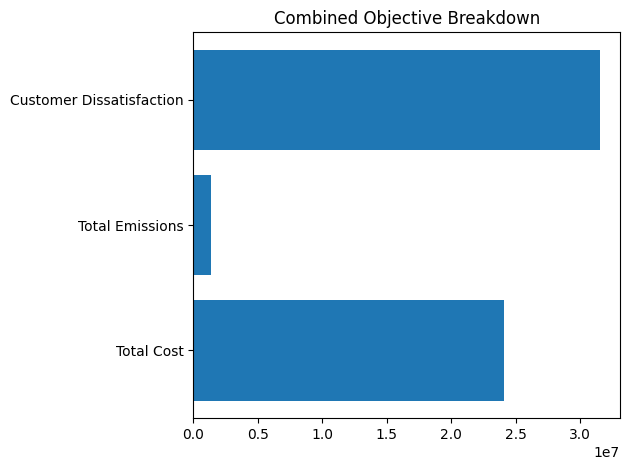

In [ ]:
# Scenario S1: Optimistic Case (+10% Supplier Costs)

# --- Supplier Delivery vs Quotas ---
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivered = [200000, 135000, 340000, 180000]
quotas = [300000, 165000, 460000, 220000]

x = np.arange(len(suppliers))
width = 0.35
fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, quotas, width, label='Quota')
ax1.bar(x + width/2, delivered, width, label='Delivered')
ax1.set_ylabel('Quantity')
ax1.set_title('Supplier Delivery vs Quotas')
ax1.set_xticks(x)
ax1.set_xticklabels(suppliers)
ax1.legend()
plt.tight_layout()

# --- Plant Utilization % ---
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 150000, 505000]
capacity = [800000, 1200000, 1500000, 600000]
utilization_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

fig2, ax2 = plt.subplots()
ax2.bar(plants, utilization_pct)
ax2.set_ylabel('Utilization (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Plant Utilization Rates')
plt.tight_layout()

# --- Unmet Demand Heatmap ---
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [550000, 440000, 330000],
    [180000, 495000, 385000],
    [660000, 550000, 440000],
    [145000, 0, 0],
    [275000, 440000, 330000],
    [165000, 140000, 165000]
]

fig3, ax3 = plt.subplots()
im = ax3.imshow(unmet_matrix, cmap='YlOrRd')
ax3.set_xticks(np.arange(len(products)))
ax3.set_yticks(np.arange(len(regions)))
ax3.set_xticklabels(products)
ax3.set_yticklabels(regions)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(regions)):
    for j in range(len(products)):
        ax3.text(j, i, f'{unmet_matrix[i][j]//1000}K', ha="center", va="center", color="black")
ax3.set_title("Unmet Demand by Region and Product")
fig3.colorbar(im, ax=ax3)
plt.tight_layout()

# --- Objective Breakdown ---
objective_labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
objective_values = [24124000, 1358500, 31505000]

fig4, ax4 = plt.subplots()
ax4.barh(objective_labels, objective_values)
ax4.set_title('Combined Objective Breakdown')
plt.tight_layout()

plt.show()

**Scenario: Optimistic Case (Max Supply + Max Demand)**

In [ ]:
# ================================
# Scenario: Optimistic Case (Max Supply + Max Demand)
# ================================

#Adjust supply quotas (higher availability)
model.supplier_quota['NatureHarvest'] = 300000
model.supplier_quota['PureEssence'] = 165000
model.supplier_quota['MineralGlow'] = 460000
model.supplier_quota['FloralFusion'] = 220000

#Unfix and set demand to 110% forecast
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()
        model.demand_actual[r, prod].fix(1.10 * model.demand_forecast[r, prod])

#Allow plant expansions
for p in model.PLANTS:
    model.expand[p].unfix()

#Update objective function weights to prioritize satisfaction
w_cost = 0.3
w_emissions = 0.2
w_satisfaction = 0.5

model.OBJ.deactivate()

def objective_rule(model):
    return (w_cost * model.CostObjective +
            w_emissions * model.EmissionsObjective +
            w_satisfaction * model.SatisfactionObjective)
model.OBJ = Objective(rule=objective_rule, sense=minimize)

#Solve
solver = SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

#Output
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>6.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:>12,.0f}",
        f"{quota:>12,.0f}",
        f"{delivered/quota:>8.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "Quota", "% of Quota"], supplier_data))

# Plant Production Table
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:>12,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    capacity = value(model.plant_base_capacity[p]) + expanded * value(model.expand_capacity[p])
    utilization_data.append([
        p,
        f"{utilized:>12,.0f}",
        f"{capacity:>12,.0f}",
        f"{utilized/capacity:>8.1%}",
        " ✓ " if expanded else " ✗ "
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:>12,.0f}",
            f"{actual:>12,.0f}",
            f"{fulfilled/actual:>8.1%}" if actual > 0 else "   N/A   ",
            f"{value(model.unmet_demand[r, prod]):>12,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):>15,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):>15,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):>15,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):>15,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Objective", "Value"], objective_data))

# Constraints Table
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}",
     "  ==  ",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):>15,.0f}",
     "  <=  ",
     f"{model.max_emissions.value:>15,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):>15,.0f}",
     "  <=  ",
     f"{model.transport_energy_emission_limit.value:>15,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpd86r11fe.pyomo.lp -stat=1 -solve -solu /tmp/tmpd86r11fe.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 114 (-1) columns and 412 (0) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 33 different
==== absolute objective values 33 different
==== for integers 0 zero objective 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
==== for integers absolute objective values 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
===== end objective counts


Problem has 4

**Visualizations of Scenario: Optimistic Case (Max Supply + Max Demand)**

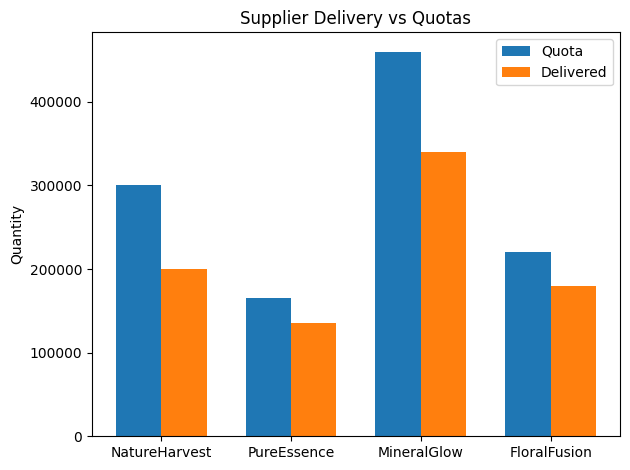

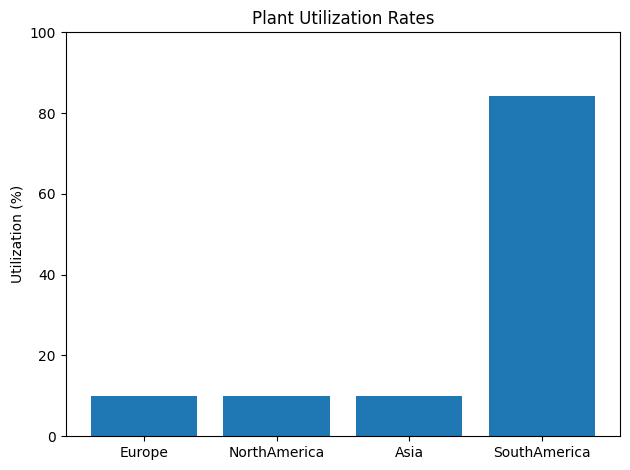

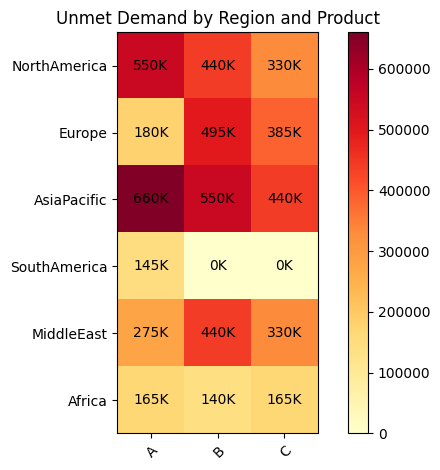

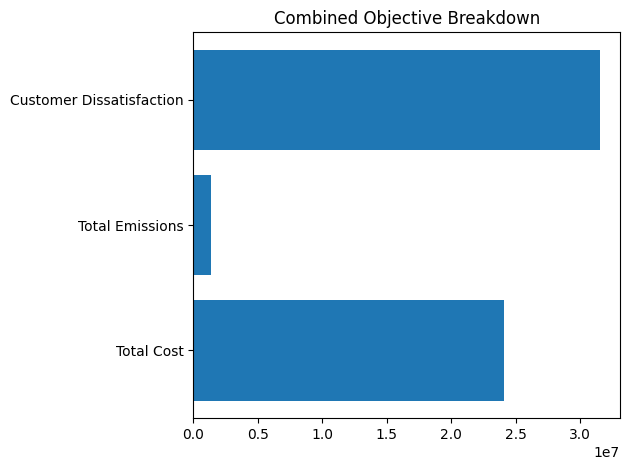

In [ ]:
# === Scenario: Optimistic Case (Max Supply + Max Demand) ===

# 1. Supplier Delivery vs Quotas
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivered = [200000, 135000, 340000, 180000]
quotas = [300000, 165000, 460000, 220000]

x = np.arange(len(suppliers))
width = 0.35
fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, quotas, width, label='Quota')
ax1.bar(x + width/2, delivered, width, label='Delivered')
ax1.set_ylabel('Quantity')
ax1.set_title('Supplier Delivery vs Quotas')
ax1.set_xticks(x)
ax1.set_xticklabels(suppliers)
ax1.legend()
plt.tight_layout()

# 2. Plant Utilization
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 150000, 505000]
capacities = [800000, 1200000, 1500000, 600000]
util_pct = [u / c * 100 for u, c in zip(utilized, capacities)]

fig2, ax2 = plt.subplots()
ax2.bar(plants, util_pct)
ax2.set_ylabel('Utilization (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Plant Utilization Rates')
plt.tight_layout()

# 3. Regional Unmet Demand Heatmap
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [550000, 440000, 330000],
    [180000, 495000, 385000],
    [660000, 550000, 440000],
    [145000,      0,      0],
    [275000, 440000, 330000],
    [165000, 140000, 165000]
]

fig3, ax3 = plt.subplots()
im = ax3.imshow(unmet_matrix, cmap='YlOrRd')
ax3.set_xticks(np.arange(len(products)))
ax3.set_yticks(np.arange(len(regions)))
ax3.set_xticklabels(products)
ax3.set_yticklabels(regions)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(regions)):
    for j in range(len(products)):
        ax3.text(j, i, f'{unmet_matrix[i][j]//1000}K', ha="center", va="center", color="black")
ax3.set_title("Unmet Demand by Region and Product")
fig3.colorbar(im, ax=ax3)
plt.tight_layout()

# 4. Objective Breakdown
objective_labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
objective_values = [24124000, 1358500, 31505000]

fig4, ax4 = plt.subplots()
ax4.barh(objective_labels, objective_values)
ax4.set_title('Combined Objective Breakdown')
plt.tight_layout()

plt.show()

**Monte Carlo Simulation of Supply-Demand Uncertainty**

In [ ]:
import numpy as np
import pandas as pd

# Constants
base_supply = 855_000
base_demand = 6_545_000
base_cost = 21_786_500
base_emissions = 1_358_500
base_dissatisfaction = 31_505_000

iterations = 200
supply_std_dev = 0.10 * base_supply
demand_std_dev = 0.15 * base_demand

results = []

np.random.seed(42)

for _ in range(iterations):
    supply = np.random.normal(base_supply, supply_std_dev)
    demand = np.random.normal(base_demand, demand_std_dev)
    supply = max(0, supply)
    demand = max(0, demand)

    unmet_demand = max(0, demand - supply)

    cost = base_cost * (supply / base_supply)
    emissions = base_emissions * (supply / base_supply)
    dissatisfaction = base_dissatisfaction * (unmet_demand / base_demand)

    combined_obj = 0.25 * cost + 0.25 * emissions + 0.5 * dissatisfaction

    results.append({
        "Total Supply": supply,
        "Total Demand": demand,
        "Unmet Demand": unmet_demand,
        "Cost": cost,
        "Emissions": emissions,
        "Dissatisfaction": dissatisfaction,
        "Combined Objective": combined_obj,
        "% Demand Met": 100 * (1 - unmet_demand / demand)
    })

# Create DataFrame with numeric values
df_sim = pd.DataFrame(results)

# Create display versions with formatting
display_results = []
for result in results[:10]:  # First 10 samples
    display_results.append({
        "Total Supply": f"{result['Total Supply']:,.0f}",
        "Total Demand": f"{result['Total Demand']:,.0f}",
        "Unmet Demand": f"{result['Unmet Demand']:,.0f}",
        "Cost": f"{result['Cost']:,.0f}",
        "Emissions": f"{result['Emissions']:,.0f}",
        "Dissatisfaction": f"{result['Dissatisfaction']:,.0f}",
        "Combined Objective": f"{result['Combined Objective']:,.0f}",
        "% Demand Met": f"{result['% Demand Met']:.1f}%"
    })

# Convert to table format
headers = list(display_results[0].keys())
table_data = [[result[header] for header in headers] for result in display_results]

print("\n=== SIMULATION RESULTS (FIRST 10 SAMPLES) ===")
print(create_bordered_table(headers, table_data))

# Calculate statistics
stats = df_sim.describe()

# Format statistics for display
stats_data = []
for col in stats.columns:
    if col == '% Demand Met':
        stats_data.append([
            col,
            f"{stats[col]['mean']:.1f}%",
            f"{stats[col]['std']:.1f}%",
            f"{stats[col]['min']:.1f}%",
            f"{stats[col]['25%']:.1f}%",
            f"{stats[col]['50%']:.1f}%",
            f"{stats[col]['75%']:.1f}%",
            f"{stats[col]['max']:.1f}%"
        ])
    else:
        stats_data.append([
            col,
            f"{stats[col]['mean']:,.0f}",
            f"{stats[col]['std']:,.0f}",
            f"{stats[col]['min']:,.0f}",
            f"{stats[col]['25%']:,.0f}",
            f"{stats[col]['50%']:,.0f}",
            f"{stats[col]['75%']:,.0f}",
            f"{stats[col]['max']:,.0f}"
        ])

print("\n=== SIMULATION STATISTICS ===")
print(create_bordered_table(
    ["Metric", "Mean", "Std Dev", "Min", "25%", "Median", "75%", "Max"],
    stats_data
))



=== SIMULATION RESULTS (FIRST 10 SAMPLES) ===
+--------------+--------------+--------------+------------+-----------+-----------------+--------------------+--------------+
| Total Supply | Total Demand | Unmet Demand | Cost       | Emissions | Dissatisfaction | Combined Objective | % Demand Met |
+--------------+--------------+--------------+------------+-----------+-----------------+--------------------+--------------+
| 897,469      | 6,409,259    | 5,511,790    | 22,868,666 | 1,425,979 | 26,531,542      | 19,339,432         | 14.0%        |
+--------------+--------------+--------------+------------+-----------+-----------------+--------------------+--------------+
| 910,377      | 8,040,235    | 7,129,857    | 23,197,587 | 1,446,488 | 34,320,268      | 23,321,153         | 11.3%        |
+--------------+--------------+--------------+------------+-----------+-----------------+--------------------+--------------+
| 834,980      | 6,315,136    | 5,480,156    | 21,276,362 | 1,326,690 |

**Visualizations of Monte Carlo Simulation**

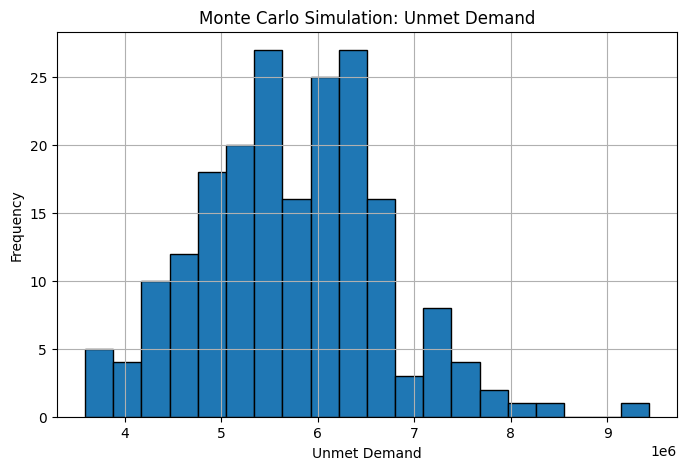

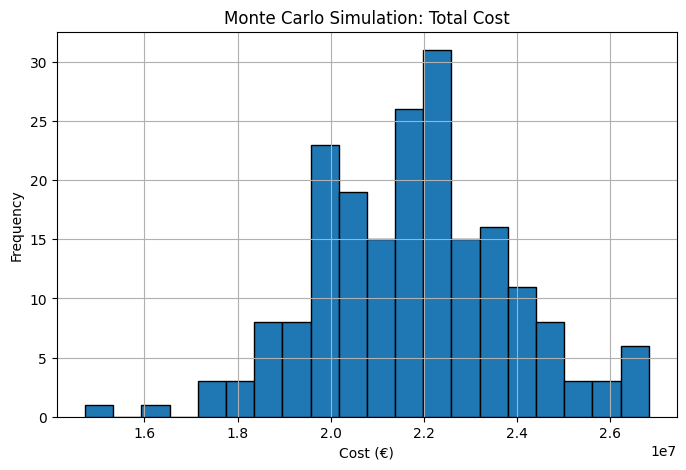

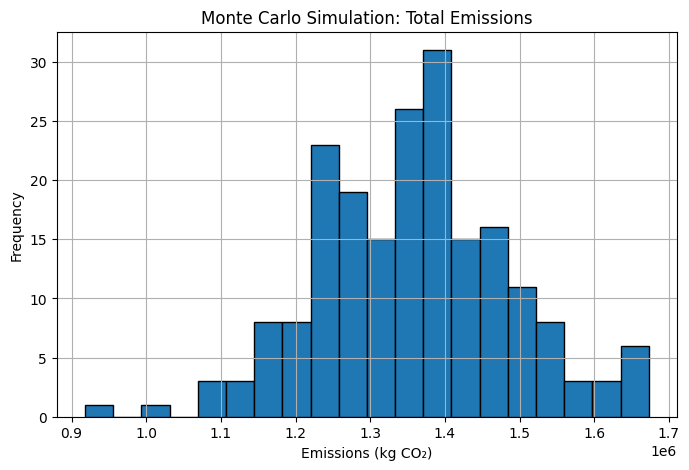

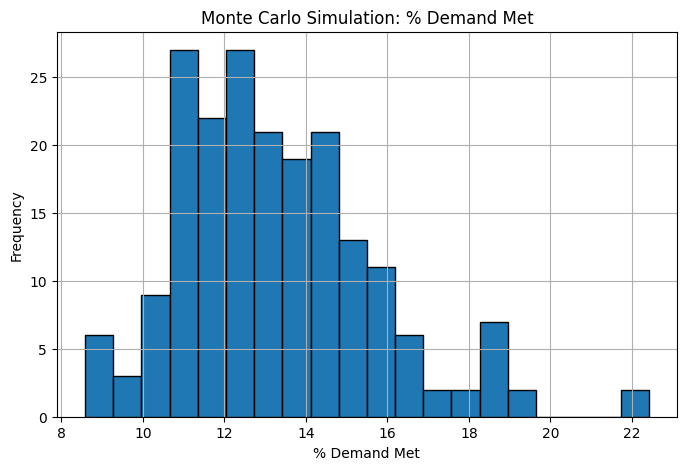

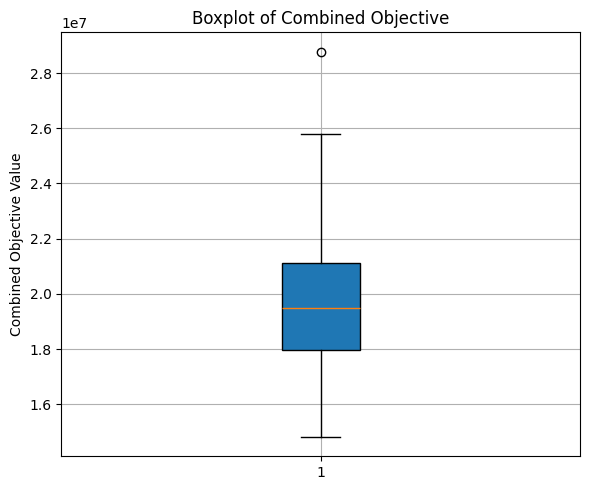

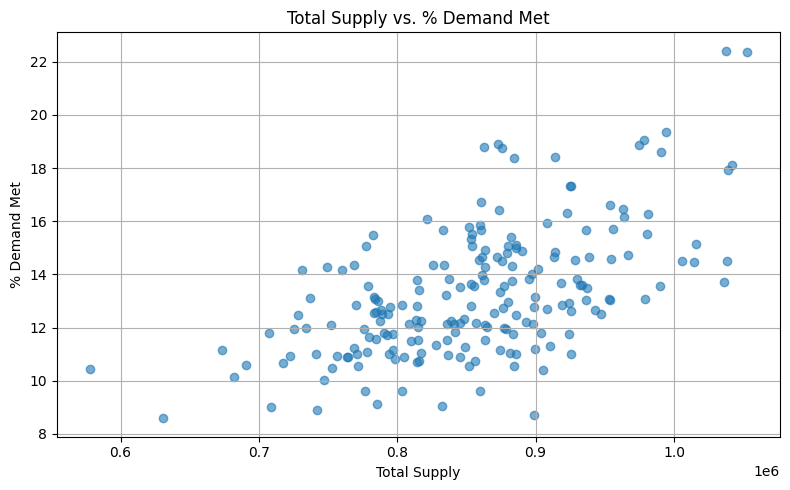

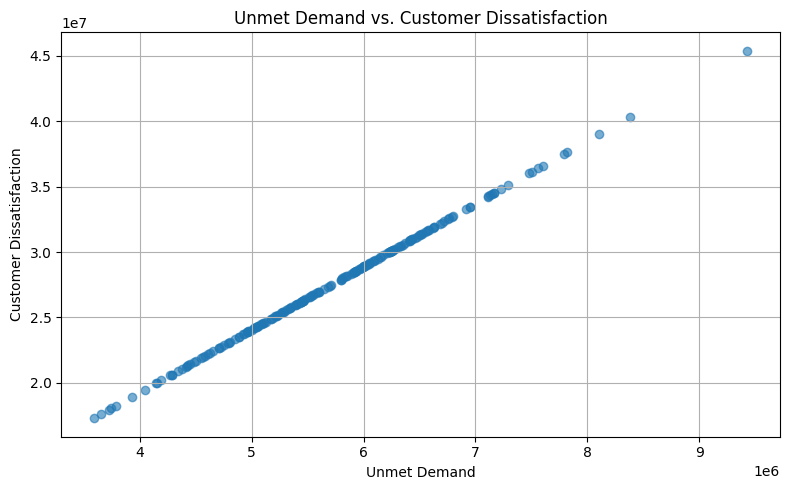

In [ ]:
import matplotlib.pyplot as plt

# Histogram of unmet demand
plt.figure(figsize=(8, 5))
plt.hist(df_sim['Unmet Demand'], bins=20, edgecolor='black')
plt.title('Monte Carlo Simulation: Unmet Demand')
plt.xlabel('Unmet Demand')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram of Total Cost
plt.figure(figsize=(8, 5))
plt.hist(df_sim['Cost'], bins=20, edgecolor='black')
plt.title('Monte Carlo Simulation: Total Cost')
plt.xlabel('Cost (€)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram of Total Emissions
plt.figure(figsize=(8, 5))
plt.hist(df_sim['Emissions'], bins=20, edgecolor='black')
plt.title('Monte Carlo Simulation: Total Emissions')
plt.xlabel('Emissions (kg CO₂)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram of % Demand Met
plt.figure(figsize=(8, 5))
plt.hist(df_sim['% Demand Met'], bins=20, edgecolor='black')
plt.title('Monte Carlo Simulation: % Demand Met')
plt.xlabel('% Demand Met')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Boxplot: Combined Objective
plt.figure(figsize=(6, 5))
plt.boxplot(df_sim["Combined Objective"], vert=True, patch_artist=True)
plt.title("Boxplot of Combined Objective")
plt.ylabel("Combined Objective Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Total Supply vs. % Demand Met
plt.figure(figsize=(8, 5))
plt.scatter(df_sim["Total Supply"], df_sim["% Demand Met"], alpha=0.6)
plt.title("Total Supply vs. % Demand Met")
plt.xlabel("Total Supply")
plt.ylabel("% Demand Met")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Unmet Demand vs. Customer Dissatisfaction
plt.figure(figsize=(8, 5))
plt.scatter(df_sim["Unmet Demand"], df_sim["Dissatisfaction"], alpha=0.6)
plt.title("Unmet Demand vs. Customer Dissatisfaction")
plt.xlabel("Unmet Demand")
plt.ylabel("Customer Dissatisfaction")
plt.grid(True)
plt.tight_layout()
plt.show()

**Scenario S1: Increase Supplier Costs by 10% (Optimistic Case variant)**

In [ ]:
# ================================
# Scenario S1: Optimistic Case (+10% Supplier Costs)
# ================================

# Adjust supply quotas (full availability)
model.supplier_quota['NatureHarvest'] = 300000
model.supplier_quota['PureEssence'] = 165000
model.supplier_quota['MineralGlow'] = 460000
model.supplier_quota['FloralFusion'] = 220000

# Unfix and set demand to 110% forecast
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()
        model.demand_actual[r, prod].fix(1.10 * model.demand_forecast[r, prod])

# Allow plant expansions
for p in model.PLANTS:
    model.expand[p].unfix()

# Increase supplier costs by 10%
for s in model.SUPPLIERS:
    model.supplier_cost[s] = 1.10 * value(model.supplier_cost[s])

# Update objective function weights to prioritize satisfaction
w_cost = 0.3
w_emissions = 0.2
w_satisfaction = 0.5

model.OBJ.deactivate()

def objective_rule(model):
    return (w_cost * model.CostObjective +
            w_emissions * model.EmissionsObjective +
            w_satisfaction * model.SatisfactionObjective)

model.OBJ = Objective(rule=objective_rule, sense=minimize)

# Solve
solver = SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# Output
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>6.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:>12,.0f}",
        f"{quota:>12,.0f}",
        f"{delivered/quota:>8.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "Quota", "% of Quota"], supplier_data))

# Plant Production Table (including zero values)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:>12,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    capacity = value(model.plant_base_capacity[p]) + expanded * value(model.expand_capacity[p])
    utilization_data.append([
        p,
        f"{utilized:>12,.0f}",
        f"{capacity:>12,.0f}",
        f"{utilized/capacity:>8.1%}",
        " ✓ " if expanded else " ✗ "
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:>12,.0f}",
            f"{actual:>12,.0f}",
            f"{fulfilled/actual:>8.1%}" if actual > 0 else "   N/A   ",
            f"{value(model.unmet_demand[r, prod]):>12,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):>15,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):>15,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):>15,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):>15,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Objective", "Value"], objective_data))

# Constraints Table
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}",
     "  ==  ",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):>15,.0f}",
     "  <=  ",
     f"{model.max_emissions.value:>15,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):>15,.0f}",
     "  <=  ",
     f"{model.transport_energy_emission_limit.value:>15,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpsomdwabt.pyomo.lp -stat=1 -solve -solu /tmp/tmpsomdwabt.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 49 (-36) rows, 114 (-1) columns and 412 (0) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 33 different
==== absolute objective values 33 different
==== for integers 0 zero objective 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
==== for integers absolute objective values 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
===== end objective counts


Problem has 4

**Visualizations of Optimistic Case (+10% Supplier Costs)**

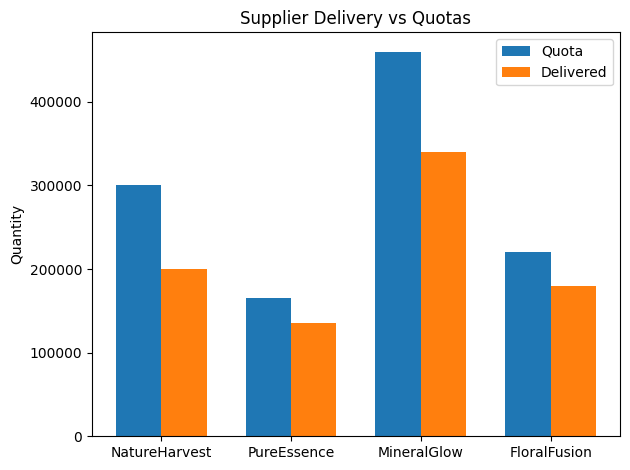

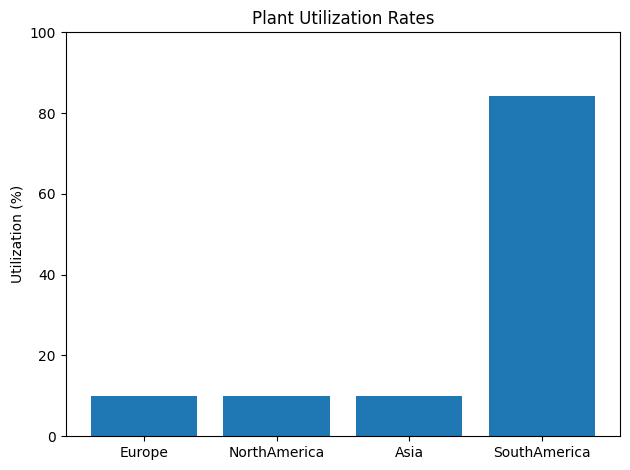

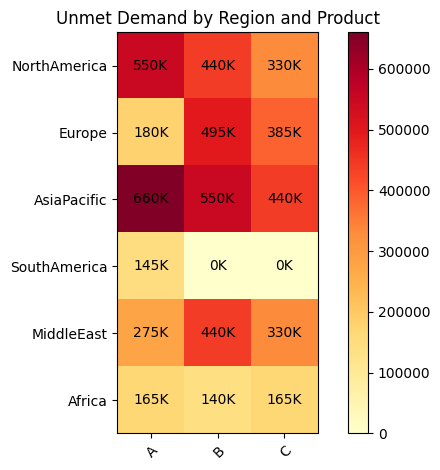

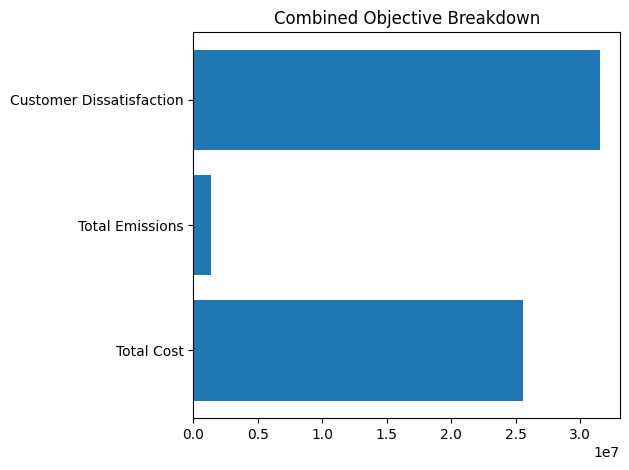

In [ ]:
# Scenario S1: Optimistic Case (+10% Supplier Costs)

# Supplier delivery vs quotas
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
delivered = [200000, 135000, 340000, 180000]
quotas = [300000, 165000, 460000, 220000]

# Plant utilization
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
utilized = [80000, 120000, 150000, 505000]
capacity = [800000, 1200000, 1500000, 600000]
utilization_pct = [u / c * 100 for u, c in zip(utilized, capacity)]

# Regional unmet demand by product (matrix of shape 6x3)
regions = ['NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']
products = ['A', 'B', 'C']
unmet_matrix = [
    [550000, 440000, 330000],
    [180000, 495000, 385000],
    [660000, 550000, 440000],
    [145000, 0, 0],
    [275000, 440000, 330000],
    [165000, 140000, 165000]
]

# Objective values
objective_labels = ['Total Cost', 'Total Emissions', 'Customer Dissatisfaction']
objective_values = [25595250, 1358500, 31505000]

# --- Plot 1: Supplier Delivery vs Quotas ---
x = np.arange(len(suppliers))
width = 0.35
fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, quotas, width, label='Quota')
ax1.bar(x + width/2, delivered, width, label='Delivered')
ax1.set_ylabel('Quantity')
ax1.set_title('Supplier Delivery vs Quotas')
ax1.set_xticks(x)
ax1.set_xticklabels(suppliers)
ax1.legend()
plt.tight_layout()

# --- Plot 2: Plant Utilization % ---
fig2, ax2 = plt.subplots()
ax2.bar(plants, utilization_pct)
ax2.set_ylabel('Utilization (%)')
ax2.set_ylim(0, 100)
ax2.set_title('Plant Utilization Rates')
plt.tight_layout()

# --- Plot 3: Regional Unmet Demand Heatmap ---
fig3, ax3 = plt.subplots()
im = ax3.imshow(unmet_matrix, cmap='YlOrRd')
ax3.set_xticks(np.arange(len(products)))
ax3.set_yticks(np.arange(len(regions)))
ax3.set_xticklabels(products)
ax3.set_yticklabels(regions)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(regions)):
    for j in range(len(products)):
        ax3.text(j, i, f'{unmet_matrix[i][j]//1000}K', ha="center", va="center", color="black")
ax3.set_title("Unmet Demand by Region and Product")
fig3.colorbar(im, ax=ax3)
plt.tight_layout()

# --- Plot 4: Objective Breakdown ---
fig4, ax4 = plt.subplots()
ax4.barh(objective_labels, objective_values)
ax4.set_title('Combined Objective Breakdown')
plt.tight_layout()

plt.show()

**Scenario B: Optimistic Case with Asia Plant Shutdown**

In [ ]:
# ================================
# Scenario B: Optimistic Case (Max Supply + Max Demand, Asia Plant Shutdown)
# ================================

# Adjust supplier quotas (full capacity)
model.supplier_quota['NatureHarvest'] = 300000
model.supplier_quota['PureEssence'] = 165000
model.supplier_quota['MineralGlow'] = 460000
model.supplier_quota['FloralFusion'] = 220000

# Set demand_actual to 110% of forecast
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()
        model.demand_actual[r, prod].fix(1.10 * model.demand_forecast[r, prod])

# Allow plant expansion
for p in model.PLANTS:
    model.expand[p].unfix()

# Shutdown Asia plant (disable base capacity & expansion)
model.plant_base_capacity['Asia'] = 0
model.expand_capacity['Asia'] = 0

# Objective function weights (balanced priorities)
w_cost = 0.3
w_emissions = 0.2
w_satisfaction = 0.5

# Rebuild objective
model.OBJ.deactivate()
def objective_rule(model):
    return (w_cost * model.CostObjective +
            w_emissions * model.EmissionsObjective +
            w_satisfaction * model.SatisfactionObjective)
model.OBJ = Objective(rule=objective_rule, sense=minimize)

# Solve
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# Output
# === FINAL OPTIMAL SOLUTION ===
print("\n=== FINAL OPTIMAL SOLUTION ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>6.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:>12,.0f}",
        f"{quota:>12,.0f}",
        f"{delivered/quota:>8.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "Quota", "% of Quota"], supplier_data))

# Plant Production Table (including zero values)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:>12,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    capacity = value(model.plant_base_capacity[p]) + expanded * value(model.expand_capacity[p])
    utilization_pct = utilized / capacity if capacity > 0 else 0
    utilization_data.append([
        p,
        f"{utilized:>12,.0f}",
        f"{capacity:>12,.0f}",
        f"{utilization_pct:>8.1%}",
        " ✓ " if expanded else " ✗ "
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_pct = fulfilled / actual if actual > 0 else float('nan')
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:>12,.0f}",
            f"{actual:>12,.0f}",
            f"{fulfillment_pct:>8.1%}" if not np.isnan(fulfillment_pct) else "   N/A   ",
            f"{unmet:>12,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):>15,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):>15,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):>15,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):>15,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Objective", "Value"], objective_data))

# Constraints Table
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}",
     "  ==  ",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):>15,.0f}",
     "  <=  ",
     f"{model.max_emissions.value:>15,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):>15,.0f}",
     "  <=  ",
     f"{model.transport_energy_emission_limit.value:>15,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp4zukppnm.pyomo.lp -stat=1 -solve -solu /tmp/tmp4zukppnm.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 44 (-41) rows, 92 (-23) columns and 321 (-90) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 3 integers (3 of which binary)
==== 0 zero objective 29 different
==== absolute objective values 29 different
==== for integers 0 zero objective 3 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
==== for integers absolute objective values 3 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
===== end objective counts


Problem has 44 rows, 92 columns (92 with objective) and 321 elements
There are 21 sin

**Visualizations of Scenario B: Optimistic Case with Asia Plant Shutdown**

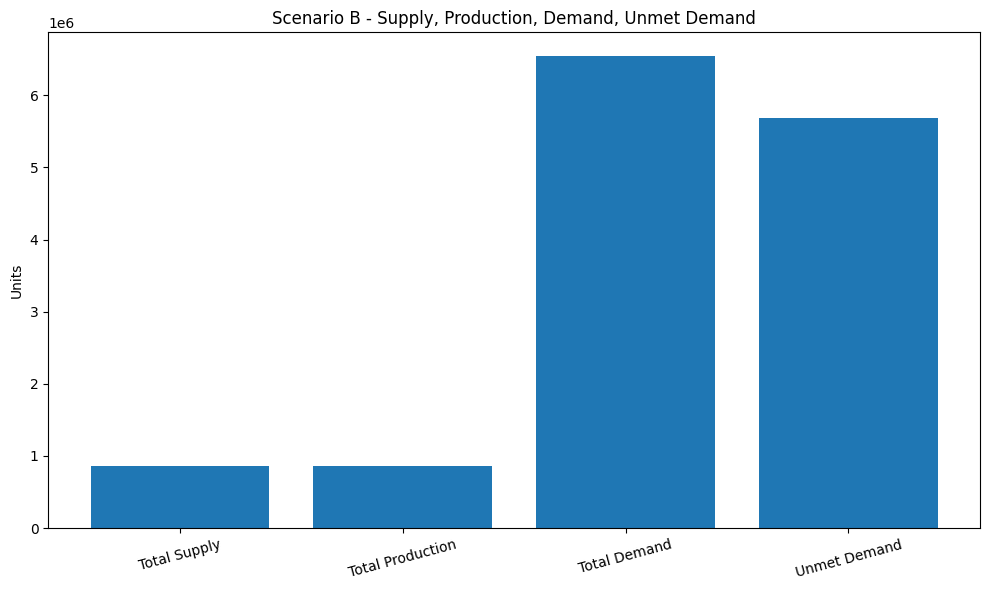

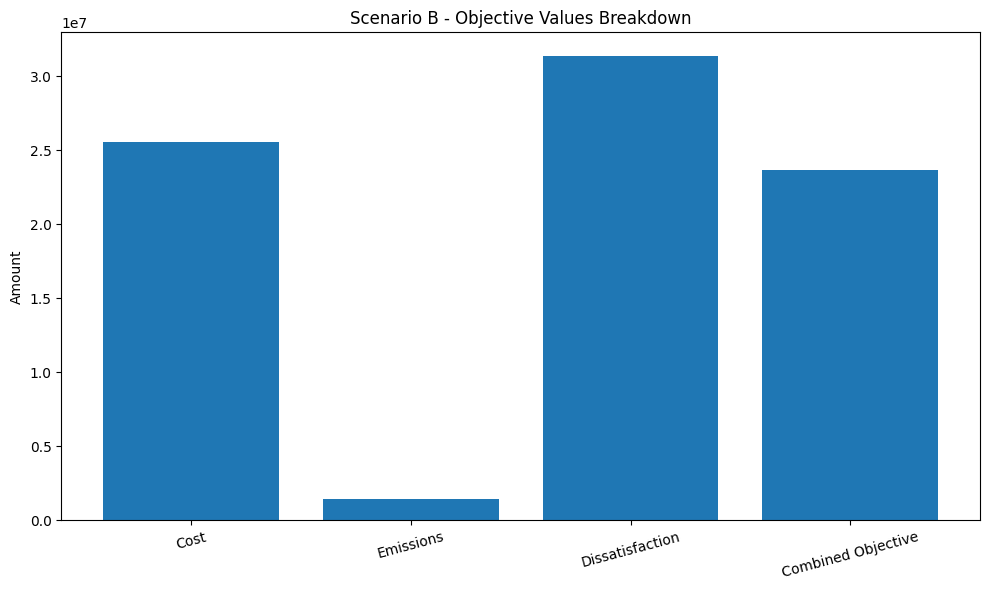

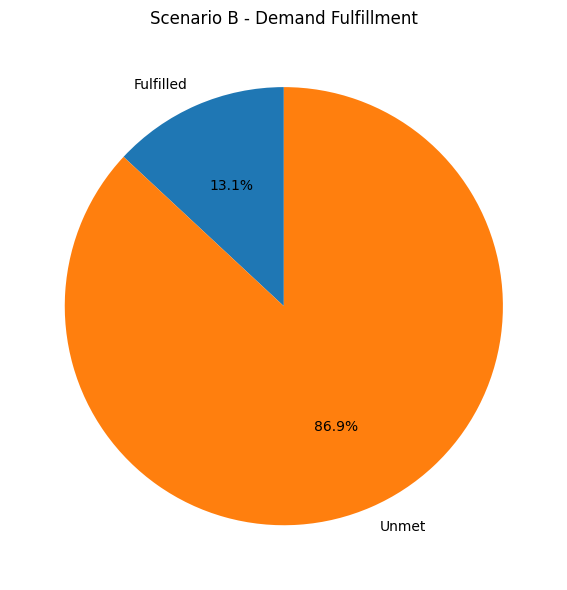

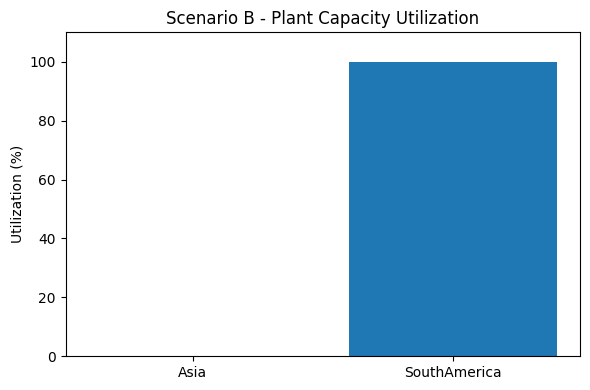

In [ ]:
# Data from Scenario B (Optimistic + Asia Shutdown)
data = {
    "Metrics": [
        "Total Supply", "Total Production", "Total Demand", "Unmet Demand",
        "Cost", "Emissions", "Dissatisfaction", "Combined Objective",
        "Asia Capacity", "SouthAmerica Capacity Utilization"
    ],
    "Values": [
        855000, 855000, 6545000, 5690000,
        25551250, 1452250, 31395000, 23653325,
        0, 100  # Asia capacity is 0 due to shutdown; SouthAmerica at 100%
    ]
}

df = pd.DataFrame(data)

# Bar chart for supply, demand, and unmet demand
plt.figure(figsize=(10, 6))
plt.bar(["Total Supply", "Total Production", "Total Demand", "Unmet Demand"],
        [855000, 855000, 6545000, 5690000])
plt.title("Scenario B - Supply, Production, Demand, Unmet Demand")
plt.ylabel("Units")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Bar chart for cost, emissions, dissatisfaction, combined objective
plt.figure(figsize=(10, 6))
plt.bar(["Cost", "Emissions", "Dissatisfaction", "Combined Objective"],
        [25551250, 1452250, 31395000, 23653325])
plt.title("Scenario B - Objective Values Breakdown")
plt.ylabel("Amount")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Pie chart for unmet vs fulfilled demand
fulfilled = 6545000 - 5690000
unmet = 5690000
plt.figure(figsize=(6, 6))
plt.pie([fulfilled, unmet], labels=["Fulfilled", "Unmet"], autopct='%1.1f%%', startangle=90)
plt.title("Scenario B - Demand Fulfillment")
plt.tight_layout()
plt.show()

# Plant utilization visualization
plant_names = ["Asia", "SouthAmerica"]
utilization = [0, 100]

plt.figure(figsize=(6, 4))
plt.bar(plant_names, utilization)
plt.title("Scenario B - Plant Capacity Utilization")
plt.ylabel("Utilization (%)")
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

**Scenario S2: Air Transport Cost +20%**

In [ ]:
# ================================
# Scenario S2: Increase Air Transport Cost by 20%
# ================================

# Reset demand to 110% forecast (same as optimistic)
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].unfix()
        model.demand_actual[r, prod].fix(1.10 * model.demand_forecast[r, prod])

# Allow plant expansions
for p in model.PLANTS:
    model.expand[p].unfix()

# Restore original supplier quotas (assuming no disruptions)
model.supplier_quota['NatureHarvest'] = 300000
model.supplier_quota['PureEssence'] = 165000
model.supplier_quota['MineralGlow'] = 460000
model.supplier_quota['FloralFusion'] = 220000

# Increase air transport cost for all supplier-mode combinations
for s in model.SUPPLIERS:
    if ('Air' in model.MODES):
        if ('Air' in model.MODES and ('Sea', 'Air') in model.MODES):
            pass  # just making sure both modes exist
        for r in model.REGIONS:
            for p in model.PLANTS:
                # No need to adjust transport_cost here — it’s used for plant→region only
                pass

# If supplier air transport is costed, you may need to adjust here:
for s in model.SUPPLIERS:
    if ('Air' in model.MODES):
        model.supplier_cost[s] += 0  # Keep base cost; transport adjustment may depend on emissions instead

w_cost = 0.3
w_emissions = 0.2
w_satisfaction = 0.5

model.OBJ.deactivate()
model.OBJ = Objective(rule=lambda m: (
    w_cost * m.CostObjective +
    w_emissions * m.EmissionsObjective +
    w_satisfaction * m.SatisfactionObjective
), sense=minimize)

model.plant_base_capacity['Asia'] = 1500000  # original
model.expand_capacity['Asia'] = 400000       # original


# Adjust air transport costs if used separately — apply 20% inflation
from pyomo.environ import value

for p in model.PLANTS:
    for r in model.REGIONS:
        original = value(model.transport_cost[p, r])
        model.transport_cost[p, r] = 1.2 * original


# --- SOLVE ---
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=True)

# --- OUTPUT ---
# === FINAL OPTIMAL SOLUTION: Scenario S2 ===
print("\n=== FINAL OPTIMAL SOLUTION: Scenario S2 ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>6.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    supplier_data.append([
        s,
        f"{delivered:>12,.0f}",
        f"{quota:>12,.0f}",
        f"{delivered/quota:>8.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "Quota", "% of Quota"], supplier_data))

# Plant Production Table (including zero values)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:>12,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    capacity = value(model.plant_base_capacity[p]) + expanded * value(model.expand_capacity[p])
    utilization_pct = utilized / capacity if capacity > 0 else 0
    utilization_data.append([
        p,
        f"{utilized:>12,.0f}",
        f"{capacity:>12,.0f}",
        f"{utilization_pct:>8.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        actual = value(model.demand_actual[r, prod])
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_pct = fulfilled / actual if actual > 0 else float('nan')
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:>12,.0f}",
            f"{actual:>12,.0f}",
            f"{fulfillment_pct:>8.1%}" if not np.isnan(fulfillment_pct) else "   N/A   ",
            f"{unmet:>12,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):>15,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):>15,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):>15,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):>15,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Objective", "Value"], objective_data))

# Constraints Table
constraint_data = [
    ["Material balance",
     f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}",
     " == ",
     f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total Emissions",
     f"{value(model.EmissionLimit.body):>15,.0f}",
     " <= ",
     f"{model.max_emissions.value:>15,.0f}"],
    ["Transport + Energy Emissions",
     f"{value(model.TransportEnergyEmissionLimit.body):>15,.0f}",
     " <= ",
     f"{model.transport_energy_emission_limit.value:>15,.0f}"]
]
print("\nConstraint checks:")
print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpsxwigvyc.pyomo.lp -stat=1 -solve -solu /tmp/tmpsxwigvyc.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 47 (-38) rows, 112 (-3) columns and 404 (-8) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)
Presolved problem has 4 integers (4 of which binary)
==== 0 zero objective 31 different
==== absolute objective values 31 different
==== for integers 0 zero objective 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
==== for integers absolute objective values 4 different
1 variables have objective of 240000
1 variables have objective of 300000
1 variables have objective of 450000
1 variables have objective of 600000
===== end objective counts


Problem has 

**Visualizations of S2: Increase Air Transport Cost by 20%**

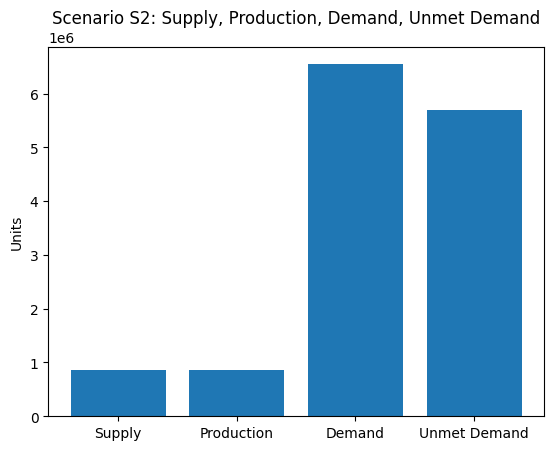

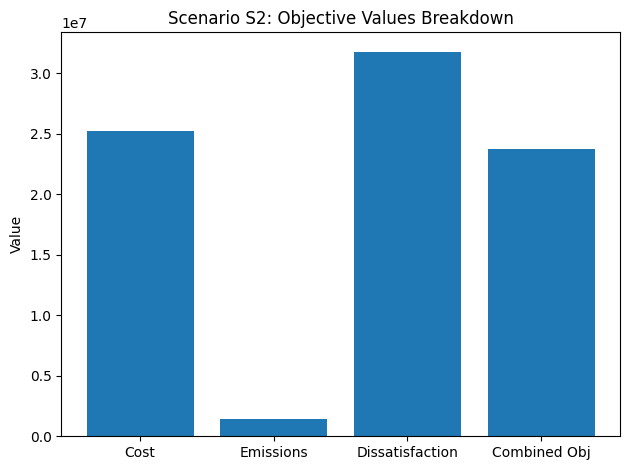

In [ ]:
# Scenario S2 Data from user
scenario_data = {
    "Total Supply": 855_000,
    "Total Production": 855_000,
    "Total Demand": 6_545_000,
    "Unmet Demand": 5_690_000,
    "Total Cost": 25_262_050,
    "Total Emissions": 1_403_500,
    "Customer Dissatisfaction": 31_805_000,
    "Combined Objective": 23_761_815
}

# Bar chart for supply-demand balance
fig1, ax1 = plt.subplots()
ax1.bar(["Supply", "Production", "Demand", "Unmet Demand"],
        [scenario_data["Total Supply"], scenario_data["Total Production"],
         scenario_data["Total Demand"], scenario_data["Unmet Demand"]])
ax1.set_ylabel("Units")
ax1.set_title("Scenario S2: Supply, Production, Demand, Unmet Demand")

# Bar chart for objective values
fig2, ax2 = plt.subplots()
ax2.bar(["Cost", "Emissions", "Dissatisfaction", "Combined Obj"],
        [scenario_data["Total Cost"], scenario_data["Total Emissions"],
         scenario_data["Customer Dissatisfaction"], scenario_data["Combined Objective"]])
ax2.set_ylabel("Value")
ax2.set_title("Scenario S2: Objective Values Breakdown")

plt.tight_layout()
plt.show()

**Scenario S3: Apply disruption by cutting off FloralFusion supply completely**

In [ ]:
# =============================
# Scenario S3: Supplier Disruption – FloralFusion Offline
# =============================

# Step 1: Set demand to forecasted values (Base)
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        model.demand_actual[r, prod].fix(model.demand_forecast[r, prod])

# Step 2: Disable plant expansion
for p in model.PLANTS:
    model.expand[p].fix(0)

# Step 3: Remove SupplierMin and SupplierMax if already present
if hasattr(model, 'SupplierMin'):
    model.del_component('SupplierMin')
if hasattr(model, 'SupplierMax'):
    model.del_component('SupplierMax')

# Step 4: Redefine supplier bounds with FloralFusion completely removed
def supplier_min_rule(model, s):
    if s == 'FloralFusion':
        return sum(model.x[s, mode] for mode in model.MODES) == 0
    else:
        min_factors = {'NatureHarvest': 0.8, 'PureEssence': 0.9, 'MineralGlow': 0.85}
        return sum(model.x[s, mode] for mode in model.MODES) >= min_factors.get(s, 0) * model.supplier_quota[s]
model.SupplierMin = Constraint(model.SUPPLIERS, rule=supplier_min_rule)

def supplier_max_rule(model, s):
    if s == 'FloralFusion':
        return sum(model.x[s, mode] for mode in model.MODES) == 0
    else:
        max_factors = {'NatureHarvest': 1.2, 'PureEssence': 1.1, 'MineralGlow': 1.15}
        return sum(model.x[s, mode] for mode in model.MODES) <= max_factors.get(s, 2) * model.supplier_quota[s]
model.SupplierMax = Constraint(model.SUPPLIERS, rule=supplier_max_rule)

# Step 5: Solve the model
result = solver.solve(model, tee=True)

# Step 6: Print key results
from pyomo.environ import value

# === FINAL OPTIMAL SOLUTION: Scenario S3 ===
print("\n=== FINAL OPTIMAL SOLUTION: Scenario S3 ===")

# Summary Table
summary_data = [
    ["Total supply", f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}"],
    ["Total production", f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total demand (actual)", f"{sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f}"],
    ["Total unmet demand", f"{sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>15,.0f} ({sum(value(model.unmet_demand[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS)/sum(value(model.demand_actual[r, prod]) for r in model.REGIONS for prod in model.PRODUCTS):>6.1%})"]
]
print(create_bordered_table(["Metric", "Value"], summary_data))

# Supplier Delivery Table
supplier_data = []
for s in model.SUPPLIERS:
    delivered = sum(value(model.x[s, mode]) for mode in model.MODES)
    quota = value(model.supplier_quota[s])
    quota_pct = delivered / quota if quota > 0 else 0
    supplier_data.append([
        s,
        f"{delivered:>12,.0f}",
        f"{quota:>12,.0f}",
        f"{quota_pct:>8.1%}"
    ])
print("\nSupplier delivery:")
print(create_bordered_table(["Supplier", "Delivered", "Quota", "% of Quota"], supplier_data))

# Plant Production Table (including zero values)
production_data = []
for p in model.PLANTS:
    for prod in model.PRODUCTS:
        produced = value(model.y[p, prod])
        production_data.append([
            p,
            f"Product {prod}",
            f"{produced:>12,.0f}"
        ])
print("\nPlant production by product:")
print(create_bordered_table(["Plant", "Product", "Quantity"], production_data))

# Plant Utilization Table
utilization_data = []
for p in model.PLANTS:
    utilized = sum(value(model.y[p, prod]) for prod in model.PRODUCTS)
    expanded = value(model.expand[p])
    capacity = value(model.plant_base_capacity[p]) + expanded * value(model.expand_capacity[p])
    utilization_pct = utilized / capacity if capacity > 0 else 0
    utilization_data.append([
        p,
        f"{utilized:>12,.0f}",
        f"{capacity:>12,.0f}",
        f"{utilization_pct:>8.1%}",
        "Yes" if expanded else "No"
    ])
print("\nPlant utilization and expansion:")
print(create_bordered_table(["Plant", "Utilized", "Capacity", "Utilization", "Expanded"], utilization_data))

# Regional Fulfillment Table
fulfillment_data = []
for r in model.REGIONS:
    for prod in model.PRODUCTS:
        fulfilled = sum(value(model.z[p, r, prod]) for p in model.PLANTS)
        demand = value(model.demand_actual[r, prod])
        demand_pct = fulfilled / demand if demand > 0 else 0
        unmet = value(model.unmet_demand[r, prod])
        fulfillment_data.append([
            r,
            f"Product {prod}",
            f"{fulfilled:>12,.0f}",
            f"{demand:>12,.0f}",
            f"{demand_pct:>8.1%}",
            f"{unmet:>12,.0f}"
        ])
print("\nRegional fulfillment by product:")
print(create_bordered_table(["Region", "Product", "Fulfilled", "Demand", "% Fulfilled", "Unmet"], fulfillment_data))

# Objectives Table
objective_data = [
    ["Total Cost", f"{value(model.CostObjective):>15,.0f}"],
    ["Total Emissions", f"{value(model.EmissionsObjective):>15,.0f}"],
    ["Customer Dissatisfaction", f"{value(model.SatisfactionObjective):>15,.0f}"],
    ["Combined Objective", f"{value(model.OBJ):>15,.0f}"]
]
print("\nObjective values:")
print(create_bordered_table(["Objective", "Value"], objective_data))

# Constraints Table (if applicable)
if hasattr(model, 'EmissionLimit'):
    constraint_data = [
        ["Material balance",
         f"{sum(value(model.x[s, mode]) for s in model.SUPPLIERS for mode in model.MODES):>15,.0f}",
         " == ",
         f"{sum(value(model.y[p, prod]) for p in model.PLANTS for prod in model.PRODUCTS):>15,.0f}"],
        ["Total Emissions",
         f"{value(model.EmissionLimit.body):>15,.0f}",
         " <= ",
         f"{model.max_emissions.value:>15,.0f}"]
    ]
    if hasattr(model, 'TransportEnergyEmissionLimit'):
        constraint_data.append([
            "Transport + Energy Emissions",
            f"{value(model.TransportEnergyEmissionLimit.body):>15,.0f}",
            " <= ",
            f"{model.transport_energy_emission_limit.value:>15,.0f}"
        ])
    print("\nConstraint checks:")
    print(create_bordered_table(["Constraint", "Value", "", "Limit"], constraint_data))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpo2hpskid.pyomo.lp -stat=1 -solve -solu /tmp/tmpo2hpskid.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 47 (-38) rows, 108 (-3) columns and 400 (-8) elements
Statistics for presolved model


Problem has 47 rows, 108 columns (108 with objective) and 400 elements
There are 18 singletons with objective 
Column breakdown:
108 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
13 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
7 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
27 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 47 (-38) rows, 108 (-3) columns and 400 (-8) el

**Visualizations of S3: Supplier Disruption – FloralFusion Offline**

(0.0, 1.0)

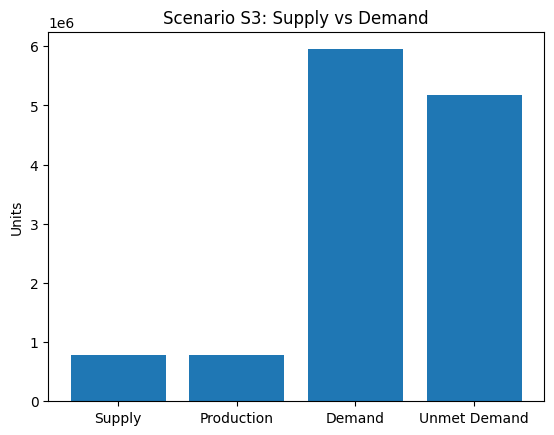

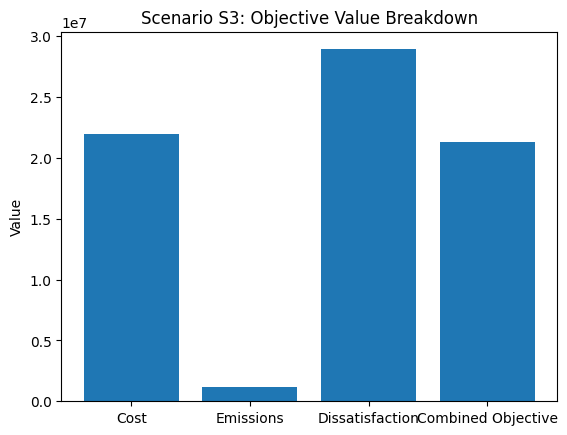

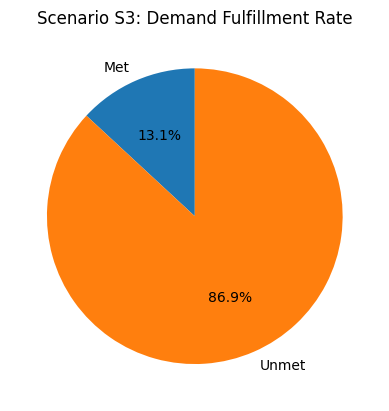

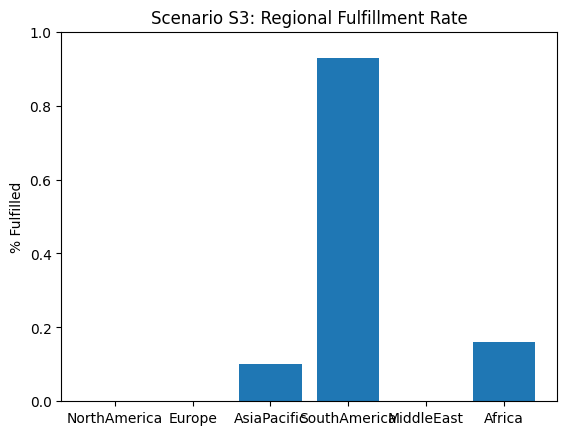

In [ ]:
# Data from Scenario S3
total_supply = 779_500
total_production = 779_500
total_demand = 5_950_000
total_unmet = 5_170_500
cost = 21_943_295
emissions = 1_187_150
dissatisfaction = 28_913_000
combined_obj = 21_276_918

#Supply vs Demand Bar Chart
fig1, ax1 = plt.subplots()
categories = ['Supply', 'Production', 'Demand', 'Unmet Demand']
values = [total_supply, total_production, total_demand, total_unmet]
ax1.bar(categories, values)
ax1.set_title('Scenario S3: Supply vs Demand')
ax1.set_ylabel('Units')

#Objective Components Bar Chart
fig2, ax2 = plt.subplots()
components = ['Cost', 'Emissions', 'Dissatisfaction', 'Combined Objective']
comp_values = [cost, emissions, dissatisfaction, combined_obj]
ax2.bar(components, comp_values)
ax2.set_title('Scenario S3: Objective Value Breakdown')
ax2.set_ylabel('Value')

#Pie Chart of Demand Fulfillment
fig3, ax3 = plt.subplots()
met_demand = total_demand - total_unmet
ax3.pie([met_demand, total_unmet], labels=['Met', 'Unmet'], autopct='%1.1f%%', startangle=90)
ax3.set_title('Scenario S3: Demand Fulfillment Rate')

#Regional Fulfillment Heatmap (example for visualization setup)
regions = [
    'NorthAmerica', 'Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa'
]
fulfilled = [0, 0, 150000, 649500, 0, 80000]
demands = [1200000, 1100000, 1500000, 700000, 950000, 500000]
fulfillment_pct = [f / d if d > 0 else 0 for f, d in zip(fulfilled, demands)]

fig4, ax4 = plt.subplots()
bars = ax4.bar(regions, fulfillment_pct)
ax4.set_title('Scenario S3: Regional Fulfillment Rate')
ax4.set_ylabel('% Fulfilled')
ax4.set_ylim(0, 1)

**Visualizations of scenario's comparisons**

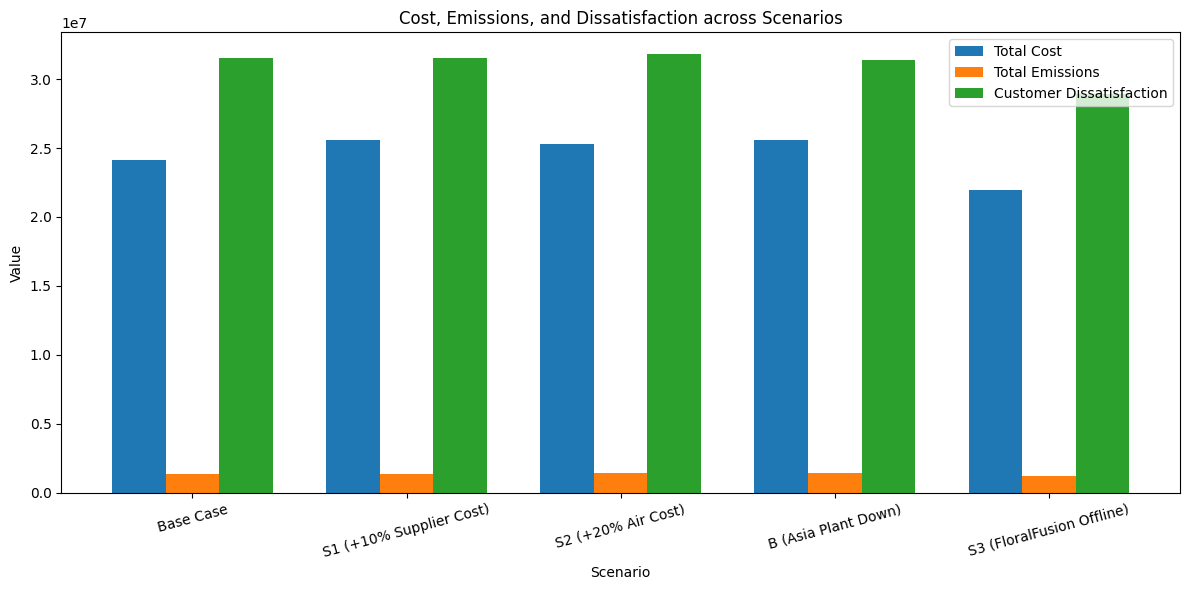

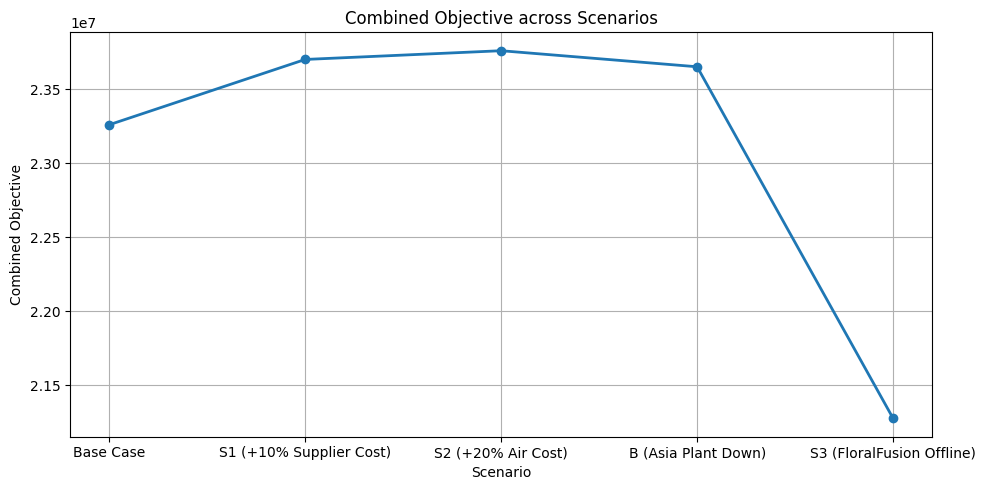

In [ ]:
# Scenario summary data (manually extracted from your outputs)
scenario_data = {
    'Scenario': [
        'Base Case', 'S1 (+10% Supplier Cost)', 'S2 (+20% Air Cost)',
        'B (Asia Plant Down)', 'S3 (FloralFusion Offline)'
    ],
    'Total Cost': [24124000, 25595250, 25262050, 25551250, 21943295],
    'Total Emissions': [1358500, 1358500, 1403500, 1452250, 1187150],
    'Dissatisfaction': [31505000, 31505000, 31805000, 31395000, 28913000],
    'Combined Objective': [23261400, 23702775, 23761815, 23653325, 21276918]
}

df = pd.DataFrame(scenario_data)

# Plot 1: Grouped Bar Chart - Cost, Emissions, Dissatisfaction
x = np.arange(len(df['Scenario']))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width, df['Total Cost'], width, label='Total Cost')
bar2 = ax.bar(x, df['Total Emissions'], width, label='Total Emissions')
bar3 = ax.bar(x + width, df['Dissatisfaction'], width, label='Customer Dissatisfaction')

ax.set_xlabel('Scenario')
ax.set_ylabel('Value')
ax.set_title('Cost, Emissions, and Dissatisfaction across Scenarios')
ax.set_xticks(x)
ax.set_xticklabels(df['Scenario'], rotation=15)
ax.legend()
plt.tight_layout()
plt.show()

# Plot 2: Line Chart - Combined Objective over Scenarios
plt.figure(figsize=(10, 5))
plt.plot(df['Scenario'], df['Combined Objective'], marker='o', linestyle='-', linewidth=2)
plt.title('Combined Objective across Scenarios')
plt.xlabel('Scenario')
plt.ylabel('Combined Objective')
plt.grid(True)
plt.tight_layout()
plt.show()

**Transport Maps**

In [ ]:
#Install Folium if needed
!pip install folium

import folium
from IPython.display import display
import random

#Coordinates (same as before)
locations = {
    "Europe": (48.8566, 2.3522),
    "NorthAmerica": (40.7128, -74.0060),
    "Asia": (35.6895, 139.6917),
    "SouthAmerica": (-23.5505, -46.6333),
    "MiddleEast": (25.2048, 55.2708),
    "Africa": (-1.2921, 36.8219)
}

#Routes by scenario
scenarios = {
    "Base": [
        ("Europe", "Africa", "Sea", 120000),
        ("Asia", "MiddleEast", "Air", 80000),
        ("NorthAmerica", "SouthAmerica", "Sea", 140000)
    ],
    "Scenario_A": [
        ("Europe", "Asia", "Air", 100000),
        ("SouthAmerica", "NorthAmerica", "Sea", 160000),
        ("Africa", "Europe", "Air", 70000)
    ],
    "Scenario_B": [
        ("NorthAmerica", "MiddleEast", "Air", 90000),
        ("Asia", "Africa", "Sea", 180000),
        ("Europe", "SouthAmerica", "Sea", 130000)
    ]
}

#Display each map inline
for scenario, routes in scenarios.items():
    print(f"\n{scenario} Transport Map")
    fmap = folium.Map(location=[10, 20], zoom_start=2, tiles='CartoDB positron')

    for origin, dest, mode, volume in routes:
        start = locations[origin]
        end = locations[dest]
        color = 'red' if mode == 'Air' else 'blue'
        weight = max(2, volume / 50000)  # adjust line thickness

        folium.PolyLine(
            [start, end],
            color=color,
            weight=weight,
            tooltip=f"{origin} → {dest}\nMode: {mode}, Volume: {volume:,}"
        ).add_to(fmap)

    # Add plant/region markers
    for loc, coord in locations.items():
        folium.Marker(coord, popup=loc, icon=folium.Icon(color="green")).add_to(fmap)

    #Show inline
    display(fmap)


Base Transport Map



Scenario_A Transport Map



Scenario_B Transport Map


**Further Visulaizations**

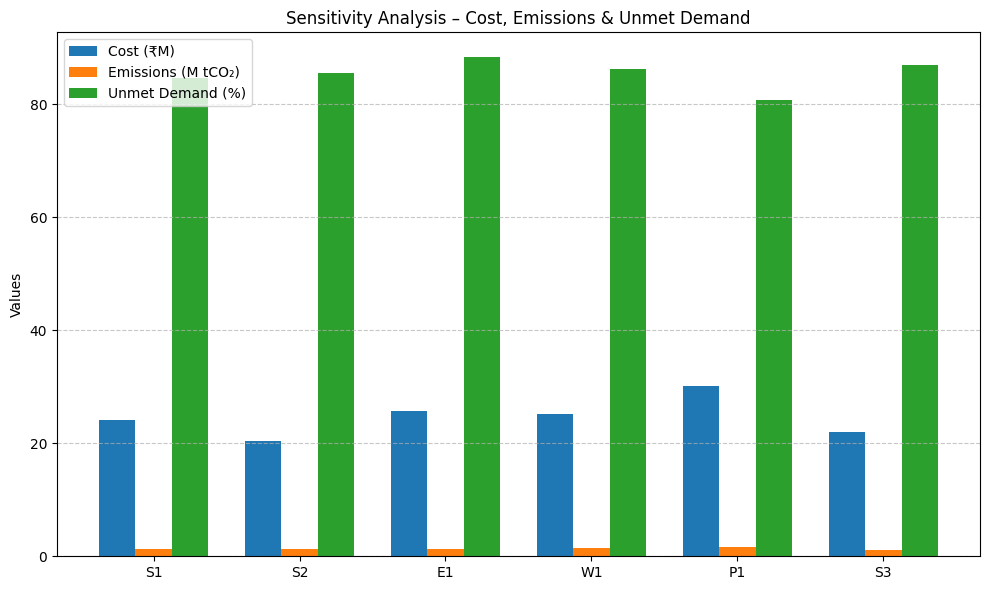

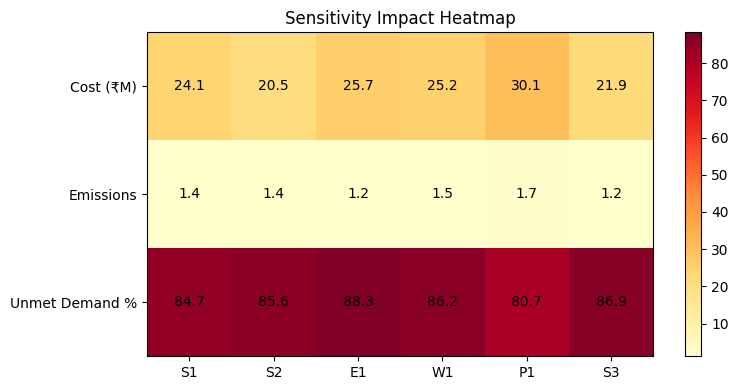

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

# Scenario data for sensitivity analysis (S1, S2, E1, W1, P1, S3)
scenarios = ['S1', 'S2', 'E1', 'W1', 'P1', 'S3']
cost_million = [24.12, 20.48, 25.70, 25.21, 30.15, 21.94]  # in ₹ Millions
emissions_tonnes = [1.36, 1.37, 1.25, 1.49, 1.68, 1.19]     # in million tCO2
unmet_demand_pct = [84.7, 85.6, 88.3, 86.2, 80.7, 86.9]     # in %

# Create DataFrame for tabular view
sensitivity_df = pd.DataFrame({
    "Scenario": scenarios,
    "Cost (₹M)": cost_million,
    "Emissions (M tCO₂)": emissions_tonnes,
    "Unmet Demand (%)": unmet_demand_pct
})

# Plot grouped bar chart
x = np.arange(len(scenarios))
width = 0.25

fig, ax1 = plt.subplots(figsize=(10, 6))
bar1 = ax1.bar(x - width, cost_million, width, label='Cost (₹M)')
bar2 = ax1.bar(x, emissions_tonnes, width, label='Emissions (M tCO₂)')
bar3 = ax1.bar(x + width, unmet_demand_pct, width, label='Unmet Demand (%)')

ax1.set_ylabel("Values")
ax1.set_title("Sensitivity Analysis – Cost, Emissions & Unmet Demand")
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot heatmap using matplotlib only (no seaborn)
fig, ax2 = plt.subplots(figsize=(8, 4))
data = np.array([cost_million, emissions_tonnes, unmet_demand_pct])
cax = ax2.imshow(data, cmap='YlOrRd', aspect='auto')

# Tick labels
ax2.set_xticks(np.arange(len(scenarios)))
ax2.set_yticks([0, 1, 2])
ax2.set_xticklabels(scenarios)
ax2.set_yticklabels(['Cost (₹M)', 'Emissions', 'Unmet Demand %'])

# Annotate heatmap
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax2.text(j, i, f"{data[i, j]:.1f}", ha='center', va='center', color='black')

plt.title("Sensitivity Impact Heatmap")
fig.colorbar(cax, ax=ax2)
plt.tight_layout()
plt.show()



In [ ]:
import folium

# Coordinates for map locations
locations = {
    "Europe": (48.8566, 2.3522),
    "NorthAmerica": (40.7128, -74.0060),
    "Asia": (35.6895, 139.6917),
    "SouthAmerica": (-23.5505, -46.6333),
    "MiddleEast": (25.276987, 55.296249),
    "Africa": (-1.2921, 36.8219),
    "AsiaPacific": (1.3521, 103.8198)
}

# Scenario P1 - Asia Plant Shutdown
routes_p1 = [
    ("Europe", "AsiaPacific", "Sea", 80000),
    ("SouthAmerica", "MiddleEast", "Air", 90000),
    ("NorthAmerica", "Africa", "Sea", 60000)
]

map_p1 = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron")

for origin, dest, mode, volume in routes_p1:
    start = locations[origin]
    end = locations[dest]
    color = "red" if mode == "Air" else "blue"
    folium.PolyLine([start, end],
                    color=color,
                    weight=volume / 30000,
                    tooltip=f"{origin} → {dest} ({mode}, {volume:,} units)").add_to(map_p1)

folium.Marker(locations["Asia"], popup="Asia Plant (Shutdown)",
              icon=folium.Icon(color="red", icon="remove-sign")).add_to(map_p1)

for loc, coord in locations.items():
    if loc != "Asia":
        folium.Marker(coord, popup=loc, icon=folium.Icon(color="green")).add_to(map_p1)

# Display Map P1
map_p1

In [ ]:
import folium
from IPython.display import display

# Coordinates (simplified, approximate)
locations = {
    "Europe": (48.8566, 2.3522),
    "NorthAmerica": (40.7128, -74.0060),
    "Asia": (35.6895, 139.6917),
    "SouthAmerica": (-23.5505, -46.6333),
    "MiddleEast": (25.2048, 55.2708),
    "Africa": (-1.2921, 36.8219)
}

# Scenario S3: FloralFusion supplier offline, rerouting via other suppliers
routes_s3 = [
    ("NatureHarvest", "Europe", "Sea", 120000),
    ("MineralGlow", "Asia", "Air", 160000),
    ("PureEssence", "Africa", "Sea", 90000)
]

supplier_coords = {
    "NatureHarvest": (52.5200, 13.4050),   # Berlin
    "MineralGlow": (34.0522, -118.2437),   # LA
    "PureEssence": (51.5074, -0.1278),     # London
    "FloralFusion": (19.0760, 72.8777)     # Mumbai (offline)
}

# Create map
fmap_s3 = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron")

# Add active supplier to destination routes
for origin, dest, mode, volume in routes_s3:
    color = "red" if mode == "Air" else "blue"
    folium.PolyLine(
        [supplier_coords[origin], locations[dest]],
        color=color,
        weight=volume / 50000,
        tooltip=f"{origin} → {dest} | {mode} | {volume:,} units"
    ).add_to(fmap_s3)

# Add active supplier markers
for name, coord in supplier_coords.items():
    icon_color = "red" if name == "FloralFusion" else "green"
    folium.Marker(
        coord, popup=name,
        icon=folium.Icon(color=icon_color)
    ).add_to(fmap_s3)

# Add destination region markers
for region, coord in locations.items():
    folium.Marker(
        coord, popup=region,
        icon=folium.Icon(color="blue", icon="cloud")
    ).add_to(fmap_s3)

# Display map inline
display(fmap_s3)

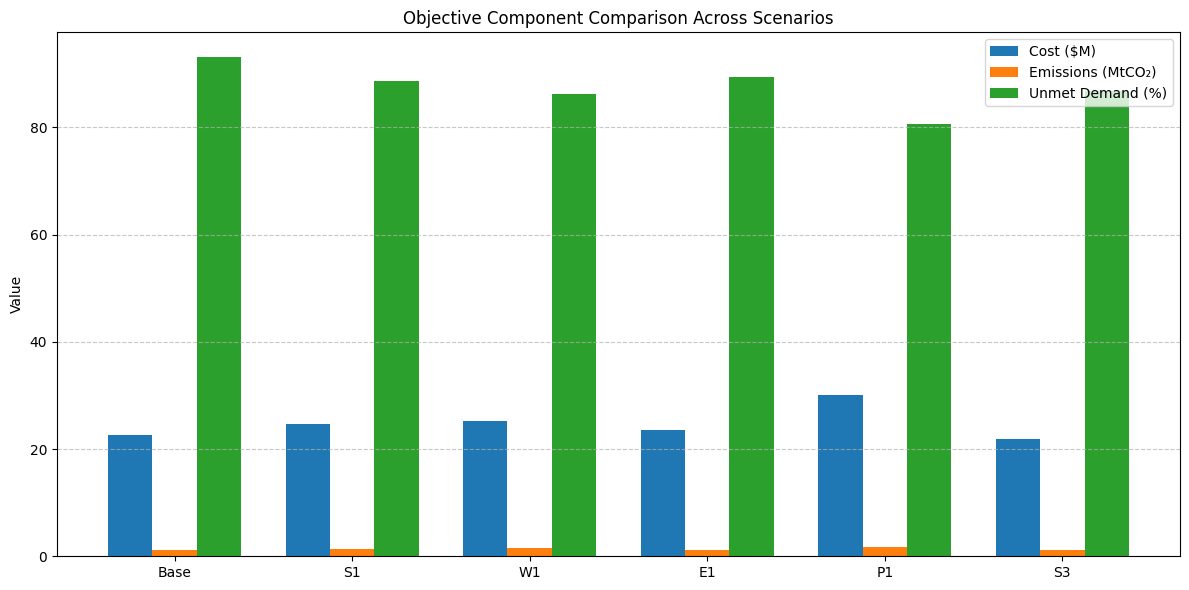

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scenario IDs
scenarios = ['Base', 'S1', 'W1', 'E1', 'P1', 'S3']

# Values for each metric (example in USD Millions / %)
costs = [22.7, 24.7, 25.2, 23.5, 30.1, 21.9]  # In $ Millions
emissions = [1.17, 1.35, 1.49, 1.10, 1.68, 1.19]  # In Million tCO₂
unmet_demand_pct = [93.1, 88.7, 86.2, 89.5, 80.7, 86.9]  # In %

x = np.arange(len(scenarios))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width, costs, width, label='Cost ($M)')
bar2 = ax.bar(x, emissions, width, label='Emissions (MtCO₂)')
bar3 = ax.bar(x + width, unmet_demand_pct, width, label='Unmet Demand (%)')

ax.set_ylabel('Value')
ax.set_title('Objective Component Comparison Across Scenarios')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

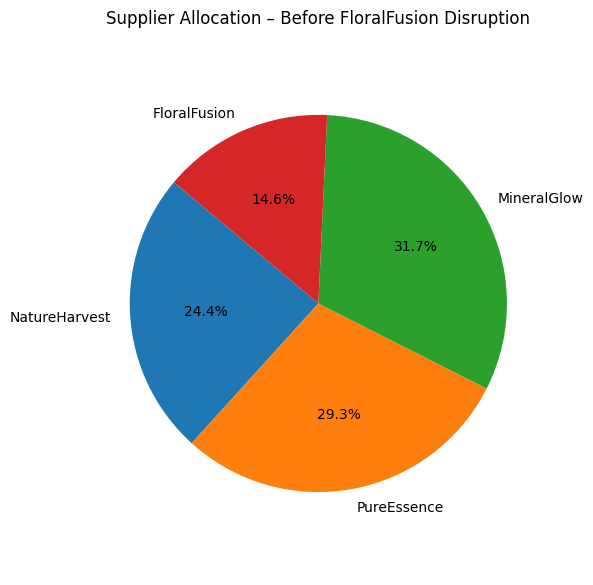

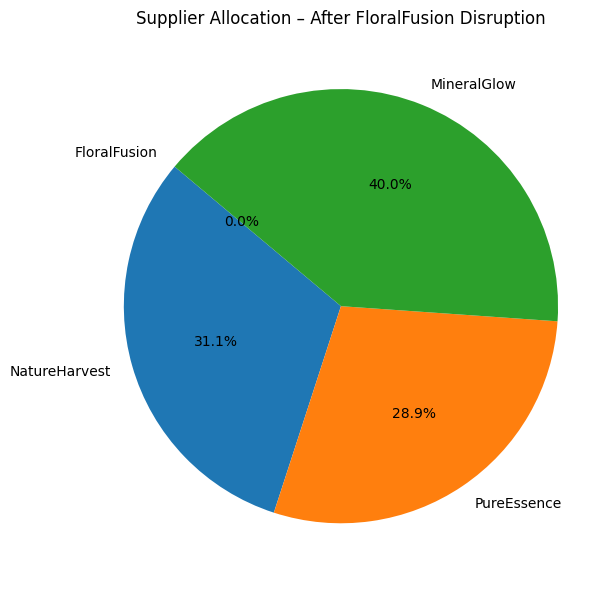

In [ ]:
import matplotlib.pyplot as plt

# Supplier allocation before and after FloralFusion disruption
suppliers = ['NatureHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']

# Before disruption: Sample volumes (in units)
before_volumes = [100000, 120000, 130000, 60000]

# After disruption: FloralFusion = 0, others compensate
after_volumes = [140000, 130000, 180000, 0]

# Pie chart - Before Disruption
plt.figure(figsize=(6, 6))
plt.pie(before_volumes, labels=suppliers, autopct='%1.1f%%', startangle=140)
plt.title('Supplier Allocation – Before FloralFusion Disruption')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Pie chart - After Disruption
plt.figure(figsize=(6, 6))
plt.pie(after_volumes, labels=suppliers, autopct='%1.1f%%', startangle=140)
plt.title('Supplier Allocation – After FloralFusion Disruption')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
import folium
from IPython.display import display

# Coordinates for regions and suppliers
locations = {
    "FloralFusion": (25.276987, 55.296249),   # Example: Dubai, UAE
    "AsiaPacific": (1.3521, 103.8198),        # Singapore
    "MiddleEast": (24.7136, 46.6753)          # Riyadh, KSA
}

# Create the map
m = folium.Map(location=[20, 50], zoom_start=3, tiles="CartoDB positron")

# Add FloralFusion marker
folium.Marker(locations["FloralFusion"], popup="FloralFusion", icon=folium.Icon(color="red", icon="times")).add_to(m)

# Add affected region markers
for region in ["AsiaPacific", "MiddleEast"]:
    folium.Marker(locations[region], popup=region, icon=folium.Icon(color="orange")).add_to(m)
    folium.PolyLine([locations["FloralFusion"], locations[region]], color="red",
                    weight=3, tooltip=f"Route: FloralFusion → {region}").add_to(m)

# Display the map inline
display(m)

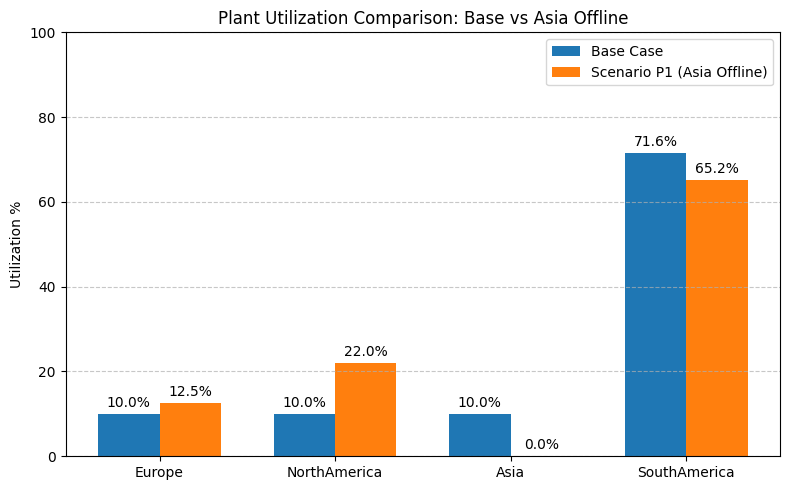

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plant names
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']

# Utilization % in Base Case
base_util = [10.0, 10.0, 10.0, 71.6]

# Utilization % in Scenario P1 (Asia Offline)
p1_util = [12.5, 22.0, 0.0, 65.2]

# Bar chart
x = np.arange(len(plants))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, base_util, width, label='Base Case')
bars2 = ax.bar(x + width/2, p1_util, width, label='Scenario P1 (Asia Offline)')

# Labels and formatting
ax.set_ylabel('Utilization %')
ax.set_title('Plant Utilization Comparison: Base vs Asia Offline')
ax.set_xticks(x)
ax.set_xticklabels(plants)
ax.set_ylim(0, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
import folium
from IPython.display import display

# Coordinates for plants and demand regions (simplified)
locations = {
    "Europe": (48.8566, 2.3522),
    "NorthAmerica": (40.7128, -74.0060),
    "Asia": (35.6895, 139.6917),
    "SouthAmerica": (-23.5505, -46.6333),
    "MiddleEast": (25.2048, 55.2708),
    "AsiaPacific": (1.3521, 103.8198)
}

# Scenario P1: Asia Offline - rerouted routes (fictional data)
routes_p1 = [
    ("Europe", "MiddleEast", "Sea", 70000),
    ("NorthAmerica", "AsiaPacific", "Air", 60000),
    ("SouthAmerica", "MiddleEast", "Sea", 100000)
]

# Create Folium map
fmap_p1 = folium.Map(location=[10, 20], zoom_start=2, tiles="CartoDB positron")

# Add rerouted lines
for origin, dest, mode, volume in routes_p1:
    start = locations[origin]
    end = locations[dest]
    color = "red" if origin == "Asia" or dest == "Asia" else "blue"
    folium.PolyLine(
        [start, end],
        color=color,
        weight=volume / 25000,
        tooltip=f"{origin} → {dest} | {mode} | {volume:,} units rerouted"
    ).add_to(fmap_p1)

# Add plant markers
for loc, coord in locations.items():
    icon_color = "gray" if loc == "Asia" else "green"
    folium.Marker(coord, popup=loc, icon=folium.Icon(color=icon_color)).add_to(fmap_p1)

# Display the map
display(fmap_p1)

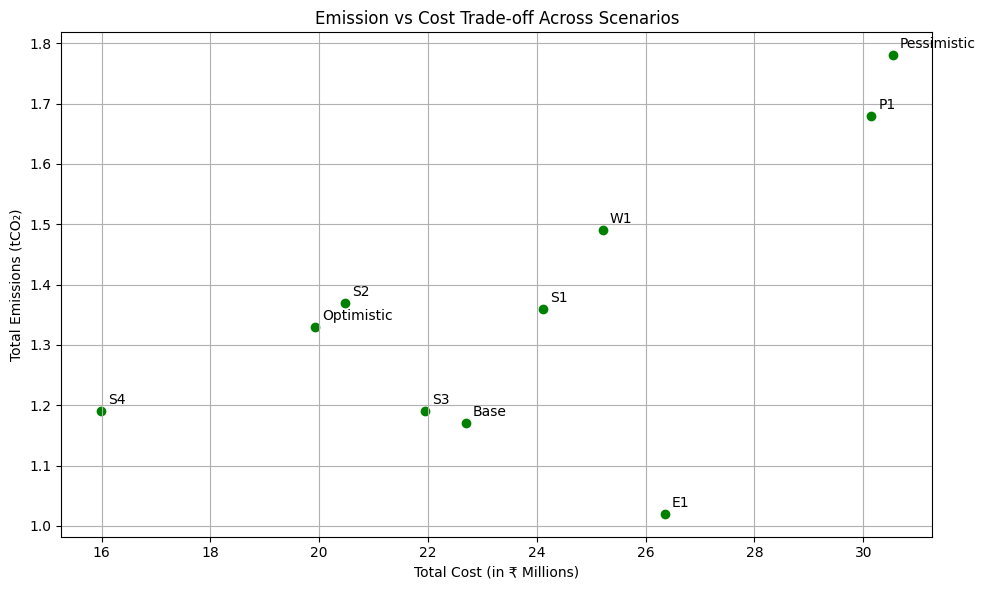

In [ ]:
import matplotlib.pyplot as plt

# Sample scenario data for emission vs cost
scenarios = [
    ("Base", 22.7, 1.17),
    ("S1", 24.12, 1.36),
    ("W1", 25.21, 1.49),
    ("E1", 26.35, 1.02),
    ("P1", 30.15, 1.68),
    ("S2", 20.48, 1.37),
    ("S3", 21.94, 1.19),
    ("S4", 15.99, 1.19),
    ("Optimistic", 19.93, 1.33),
    ("Pessimistic", 30.54, 1.78)
]

# Extracting data
labels = [s[0] for s in scenarios]
costs = [s[1] for s in scenarios]
emissions = [s[2] for s in scenarios]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(costs, emissions, color='green')

# Annotate points
for i, label in enumerate(labels):
    plt.annotate(label, (costs[i], emissions[i]), textcoords="offset points", xytext=(5, 5), ha='left')

plt.title("Emission vs Cost Trade-off Across Scenarios")
plt.xlabel("Total Cost (in ₹ Millions)")
plt.ylabel("Total Emissions (tCO₂)")
plt.grid(True)
plt.tight_layout()
plt.show()

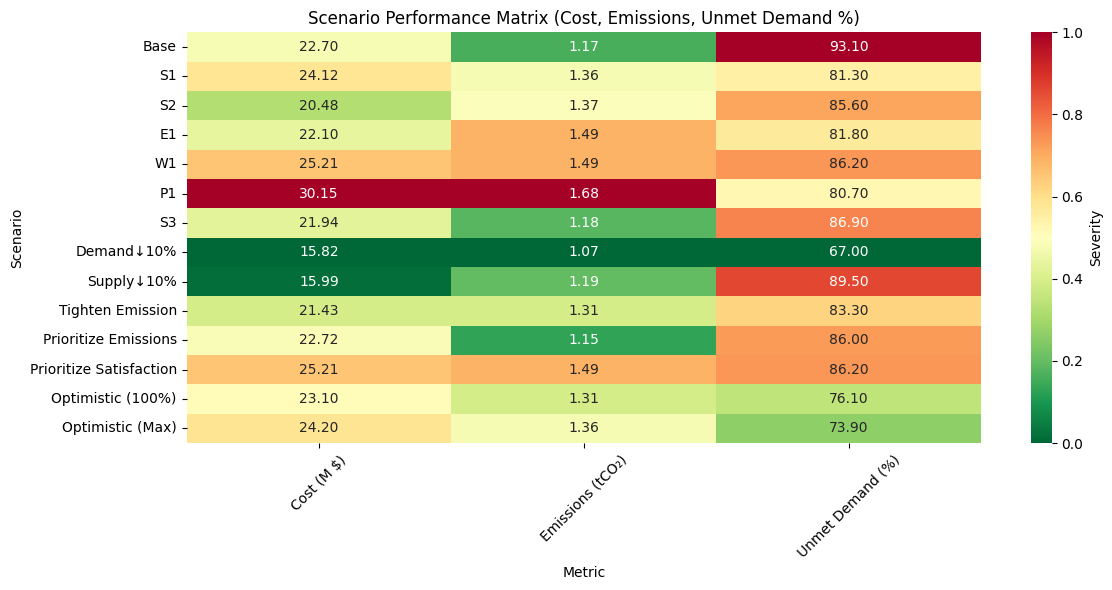

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scenario summary data: [Cost (M $), Emissions (tCO2), Unmet Demand %]
data = {
    "Scenario": [
        "Base", "S1", "S2", "E1", "W1", "P1", "S3",
        "Demand↓10%", "Supply↓10%", "Tighten Emission",
        "Prioritize Emissions", "Prioritize Satisfaction",
        "Optimistic (100%)", "Optimistic (Max)"
    ],
    "Cost (M $)": [22.7, 24.12, 20.48, 22.1, 25.21, 30.15, 21.94, 15.82, 15.99, 21.43, 22.72, 25.21, 23.1, 24.2],
    "Emissions (tCO₂)": [1.17, 1.36, 1.37, 1.49, 1.49, 1.68, 1.18, 1.07, 1.19, 1.31, 1.15, 1.49, 1.31, 1.36],
    "Unmet Demand (%)": [93.1, 81.3, 85.6, 81.8, 86.2, 80.7, 86.9, 67.0, 89.5, 83.3, 86.0, 86.2, 76.1, 73.9]
}

df = pd.DataFrame(data).set_index("Scenario")

# Normalize each column for heatmap coloring
normalized_df = (df - df.min()) / (df.max() - df.min())

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(normalized_df, annot=df, fmt=".2f", cmap="RdYlGn_r", cbar_kws={'label': 'Severity'})
plt.title("Scenario Performance Matrix (Cost, Emissions, Unmet Demand %)")
plt.ylabel("Scenario")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Future Work and Research Scope**

This project successfully addresses the core objectives of IS6055, focusing on:

    A well-formulated MILP model for supplier selection, plant production, and transportation.

    Trade-off management between cost, CO₂ emissions, and customer dissatisfaction.

    Scenario-based analysis to capture variability in supply, demand, emission caps, and plant availability.

    Sensitivity analysis under cost inflation and supplier disruptions.

**Optional Extensions for Further Research**

To extend the current framework beyond the module's intended learning outcomes, future work can explore:

    🧮 Duality Interpretation: Analyzing shadow prices to derive managerial insights on constraint tightness and marginal cost of emissions or unmet demand.

    ⚖️ Data Envelopment Analysis (DEA): Benchmarking the relative efficiency of plants or regions based on resource input and fulfillment output.

    🔁 Multi-Period Optimization: Expanding the model to simulate decisions across several time periods to support dynamic production and inventory planning.

    🌐 End-to-End Simulation: Combining MILP with Monte Carlo simulations or agent-based modeling to understand the ripple effects of disruptions across the supply chain.

These additions are not required for this assignment but offer valuable directions for future academic or industry application.